### Loading the Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

### Loading the Dataset

In [4]:
location = 'D:/BDS Docs/Year 1/Internship/Covid Data/Global COVID-19 Cases.csv'
df = pd.read_csv(location)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219718 entries, 0 to 219717
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Province/State  197515 non-null  object 
 1   Country/Region  219718 non-null  object 
 2   Lat             216080 non-null  float64
 3   Long            216080 non-null  float64
 4   Date            219718 non-null  object 
 5   Confirmed       219718 non-null  int64  
 6   Deaths          219718 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 11.7+ MB


### Removing unnecessary columns

In [7]:
cols = ['Lat', 'Long']

df.drop(cols, axis = 1, inplace = True)

### Removing the rows containing 0 values for the confirmed number of cases

In [8]:
df = df[df['Confirmed'] != 0]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199538 entries, 49 to 219717
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Province/State  184068 non-null  object
 1   Country/Region  199538 non-null  object
 2   Date            199538 non-null  object
 3   Confirmed       199538 non-null  int64 
 4   Deaths          199538 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 9.1+ MB


### Converting the Date column into two separate columns, Date and Month

In [10]:
def convert_date(target):
    dates = []
    months = []
    for date in target:
        if re.search('/', date):
            temp = date.split('/')
            dates.append(int(temp[1]))
            months.append(int(temp[0]))
        elif re.search('-', date):
            temp = date.split('-')
            dates.append(int(temp[1]))
            months.append(int(temp[0]))
    
    return dates, months

In [11]:
dates, months = convert_date(df['Date'])

In [12]:
df['Date'] = dates
df.insert(3, 'Month', months)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199538 entries, 49 to 219717
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Province/State  184068 non-null  object
 1   Country/Region  199538 non-null  object
 2   Date            199538 non-null  int64 
 3   Month           199538 non-null  int64 
 4   Confirmed       199538 non-null  int64 
 5   Deaths          199538 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 10.7+ MB


### Renaming certain columns

In [14]:
df.rename(columns={'Province/State': 'State', 'Country/Region': 'Country'}, inplace = True)
df.columns

Index(['State', 'Country', 'Date', 'Month', 'Confirmed', 'Deaths'], dtype='object')

### Making a new dataframe
df2 contains no duplicate value for a country on a particular date

In [15]:
countries = []
dates = []
months = [] 
confirmed = []
deaths = []

for month in df.Month.unique():
    temp = df[df['Month'] == month]
    for date in temp.Date.unique():
        temp2 = temp[temp['Date'] == date]
        for country in temp2.Country.unique():
            temp3 = temp2[temp2['Country'] == country]
            countries.append(country)
            dates.append(date)
            months.append(month)
            confirmed.append(temp3['Confirmed'].sum())
            deaths.append(temp3['Deaths'].sum())

In [16]:
df2 = pd.DataFrame({'Country': countries,
                   'Date': dates,
                   'Month': months,
                   'Confirmed': confirmed,
                   'Death': deaths})

### Adding serial numbers to the dataset
New column 'Ixs' will be added to df2

In [17]:
serials = np.arange(1, len(df2)+1)
df2.insert(0, 'Ixs', serials)

### Adding new features to df2 
The new column New_confirmed and New_deaths will be containing the number of new cases and new deaths respectively everyday countrywise

In [18]:
df2.sort_values(['Country', 'Ixs'], inplace = True)

new_cases = []
new_deaths = []

for country in df2.Country.unique():
    temp = df2[df2['Country'] == country]
    confirmed = np.array(temp['Confirmed'])
    deaths = np.array(temp['Death'])
    
    for i, c in enumerate(confirmed):
        if i>0:
            new = c - confirmed[i-1]
            new_cases.append(new)
        else:
            new_cases.append(c)
            
    for i, d in enumerate(deaths):
        if i>0:
            new = d - deaths[i-1]
            new_deaths.append(new)
        else:
            new_deaths.append(d)

In [19]:
df2['New_cases'] = new_cases
df2['New_deaths'] = new_deaths

In [20]:
df2.sort_values('Ixs', inplace = True)

### Adding a new colum to df2
New column will contain the combined date and month

In [21]:
combined_date = []
date = np.array(df2['Date'])
month = np.array(df2['Month'])

for i, d in enumerate(date):
    combined_date.append(f'{d}/{month[i]}')
df2['Combined_Date'] = combined_date

### Code for plotting graphs of individual countries


In [43]:
def plot_monthwise(country, sub_group = True, multiple = False):
    if not multiple:
        if sub_group:
            temp = df2[df2['Country'] == country]
        else:
            temp = df3
    else:
        temp = pd.DataFrame()
        for i, c in enumerate(country):
            temp = pd.concat([temp, df2[df2['Country'] == c]])
        
    plt.figure(figsize = (40, 30))
    
    def month_plot(month_name, month_position):
        month_size = max(temp['Month'])
        
        temp1 = temp[temp['Month'] == month_position]

        plt.subplot(4, month_size, month_position)
        plt.bar(temp1['Date'], temp1['Confirmed'])
        plt.title(f'Number of cases of infections in \n {country} in the month of {month_name}')
        plt.xlabel('Date')
        plt.ylabel('Number of Cases')

        plt.subplot(4, month_size, month_position + month_size*1)
        plt.bar(temp1['Date'], temp1['New_cases'])
        plt.title(f'Number of new cases of infections in \n {country} in the month of {month_name}')
        plt.xlabel('Date')
        plt.ylabel('Number of New Cases')

        plt.subplot(4, month_size, month_position + month_size*2)
        plt.bar(temp1['Date'], temp1['Death'])
        plt.title(f'Number of deaths in \n {country} in the month of {month_name}')
        plt.xlabel('Date')
        plt.ylabel('Number of Deaths')

        plt.subplot(4, month_size, month_position + month_size*3)
        plt.bar(temp1['Date'], temp1['New_deaths'])
        plt.title(f'Number of new deaths in \n {country} in the month of {month_name}')
        plt.xlabel('Date')
        plt.ylabel('Number of New Deaths')

    month_plot('January', 1)
    month_plot('February', 2)
    month_plot('March', 3)
    month_plot('April', 4)
    month_plot('May', 5)
    
    plt.tight_layout()
    plt.show()

In [44]:
def plot_total(country, sub_group = True, multiple = False):
    if not multiple:
        if sub_group:
            temp = df2[df2['Country'] == country]
        else:
            temp = df3
    else:
        temp = pd.DataFrame()
        for i, c in enumerate(country):
            temp = pd.concat([temp, df2[df2['Country'] == c]])

    plt.figure(figsize = (40, 40))

    plt.subplot(4,1,1)
    plt.bar(temp['Combined_Date'], temp['Confirmed'])
    plt.title(f'Number of cases of infections in\n {country} from January to May')
    plt.xlabel('Date')
    plt.ylabel('Number of Cases')
    plt.xticks(rotation = 90)

    plt.subplot(4,1,2)
    plt.bar(temp['Combined_Date'], temp['New_cases'])
    plt.title(f'Number of new cases of infections in\n {country} from January to May')
    plt.xlabel('Date')
    plt.ylabel('Number of New Cases')
    plt.xticks(rotation = 90)


    plt.subplot(4,1,3)
    plt.bar(temp['Combined_Date'], temp['Death'])
    plt.title(f'Number of deaths in\n {country} from January to May')
    plt.xlabel('Date')
    plt.ylabel('Number of Deaths')
    plt.xticks(rotation = 90)

    plt.subplot(4,1,4)
    plt.bar(temp['Combined_Date'], temp['New_deaths'])
    plt.title(f'Number of new deaths in\n {country} from January to May')
    plt.xlabel('Date')
    plt.ylabel('Number of New Deaths')
    plt.xticks(rotation = 90)

    plt.tight_layout()
    plt.show()

### Plotting graphs for China

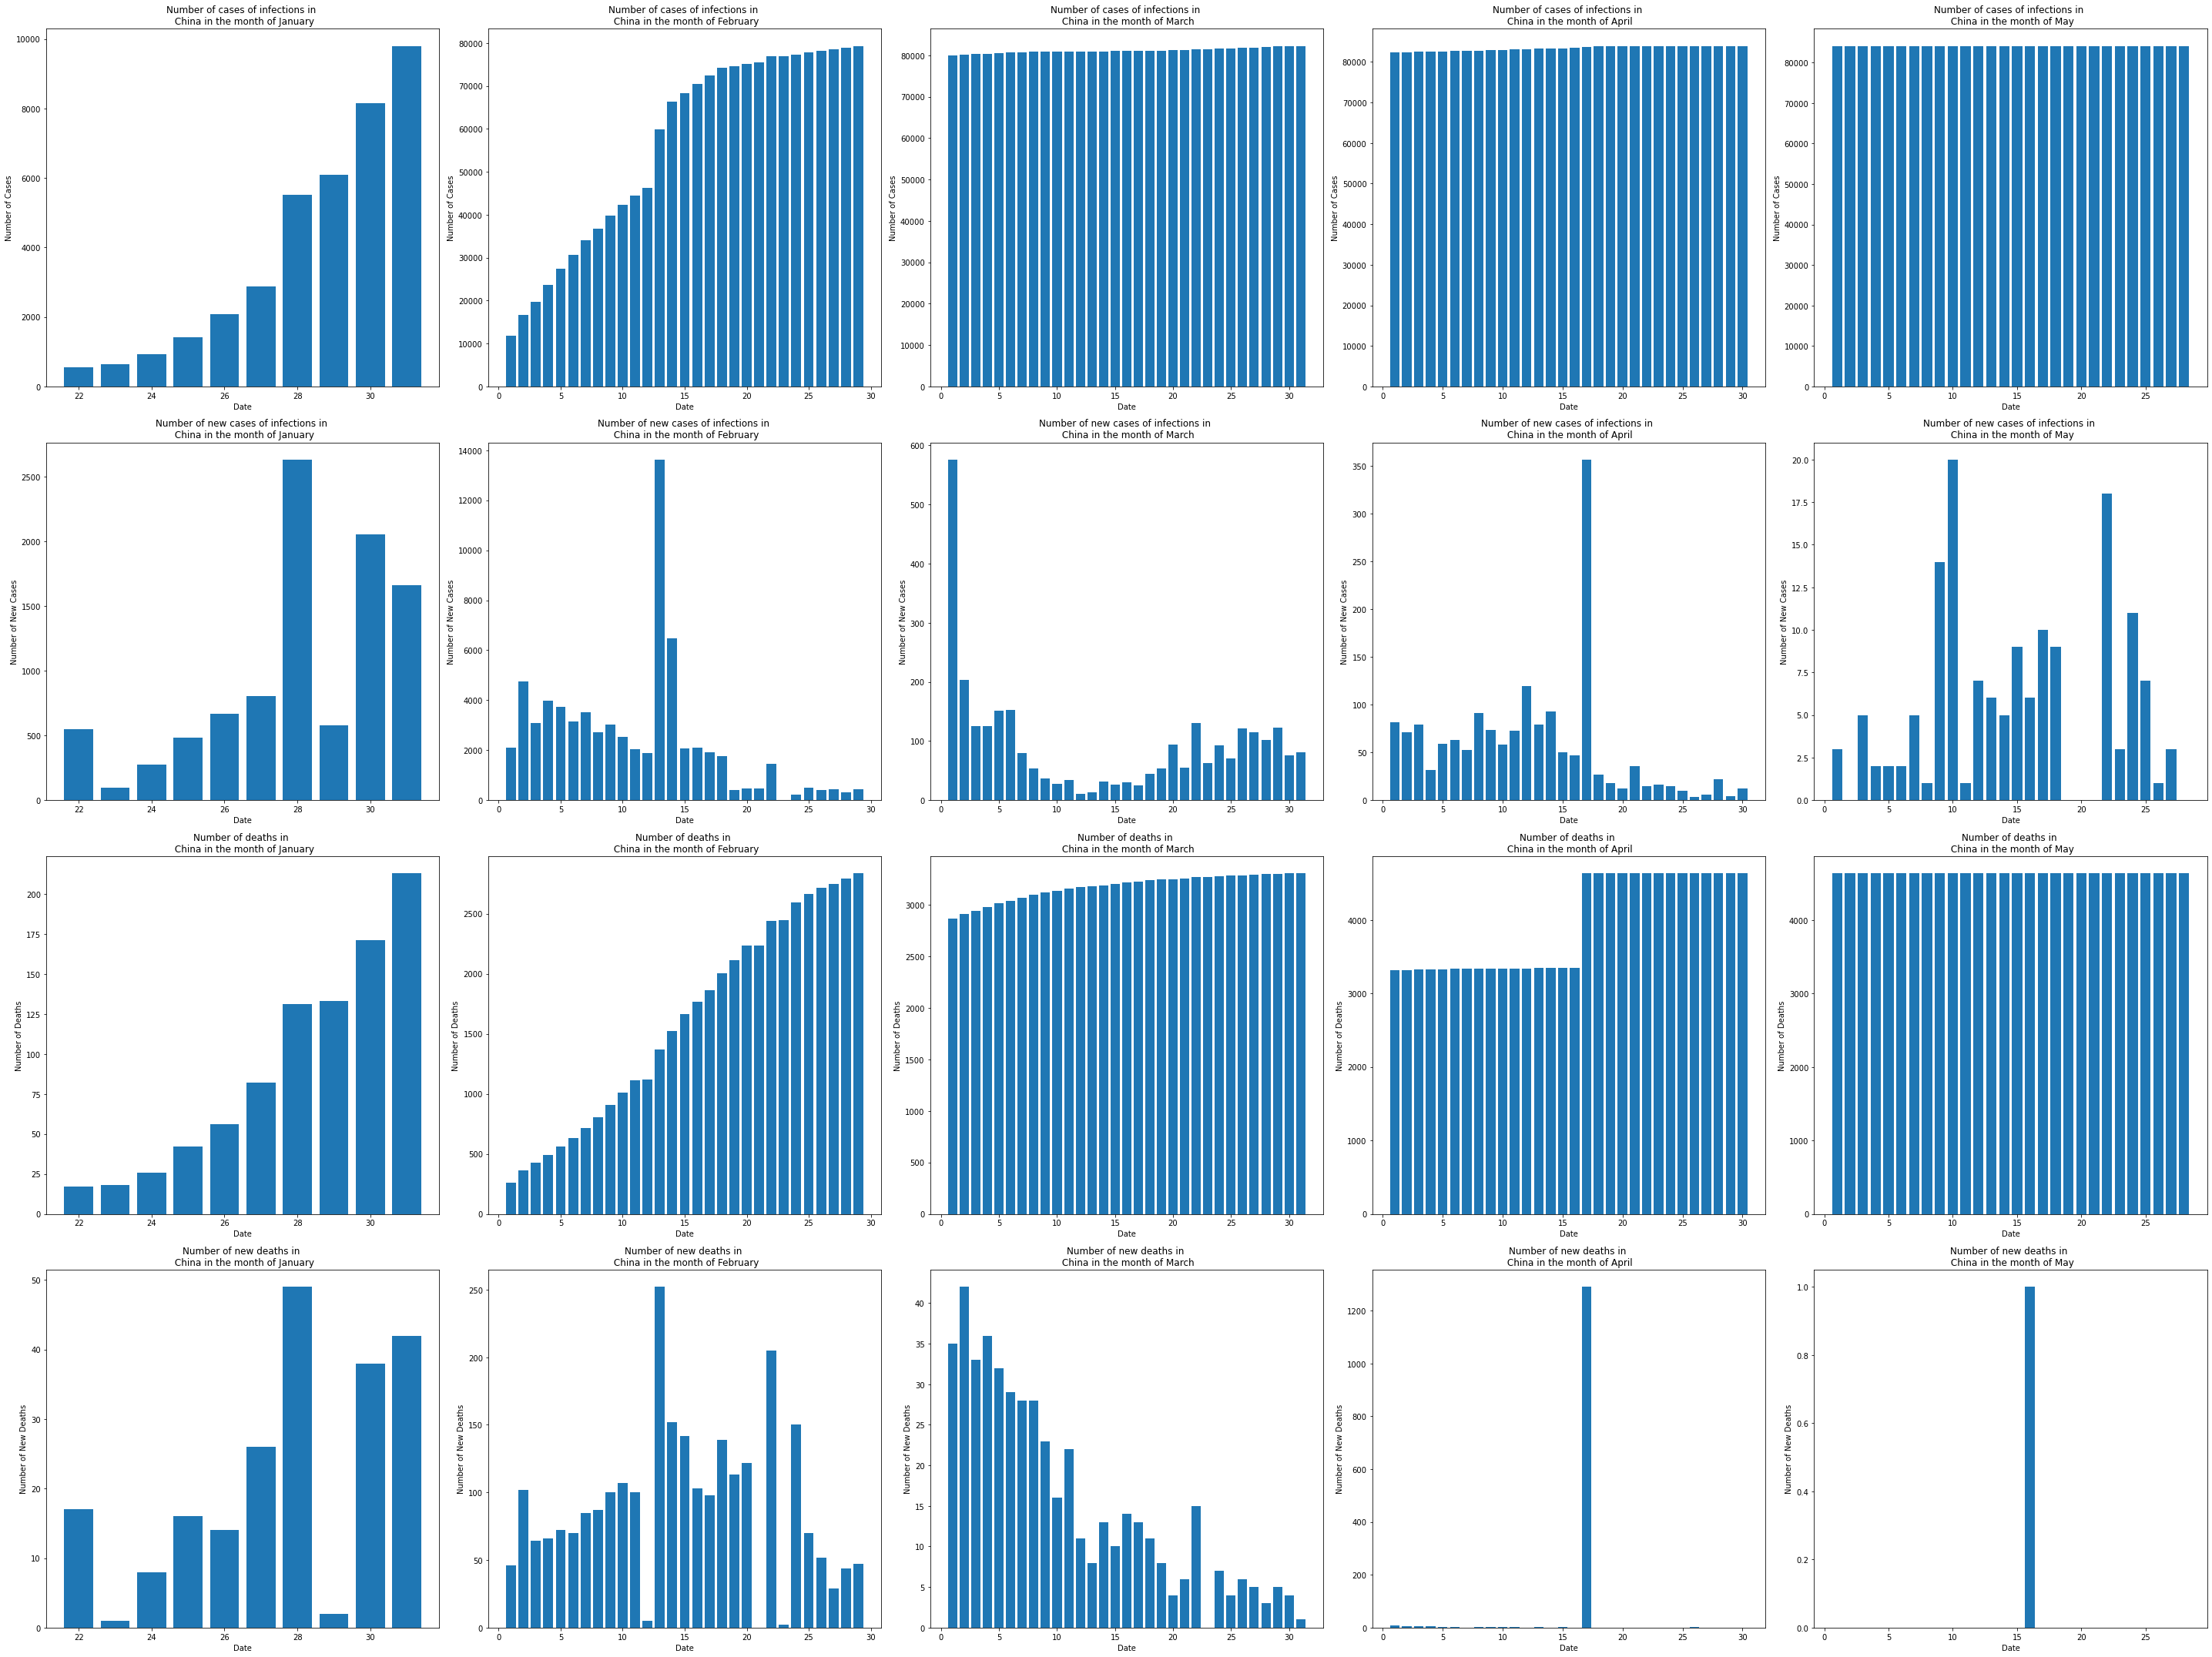

In [45]:
plot_monthwise('China')

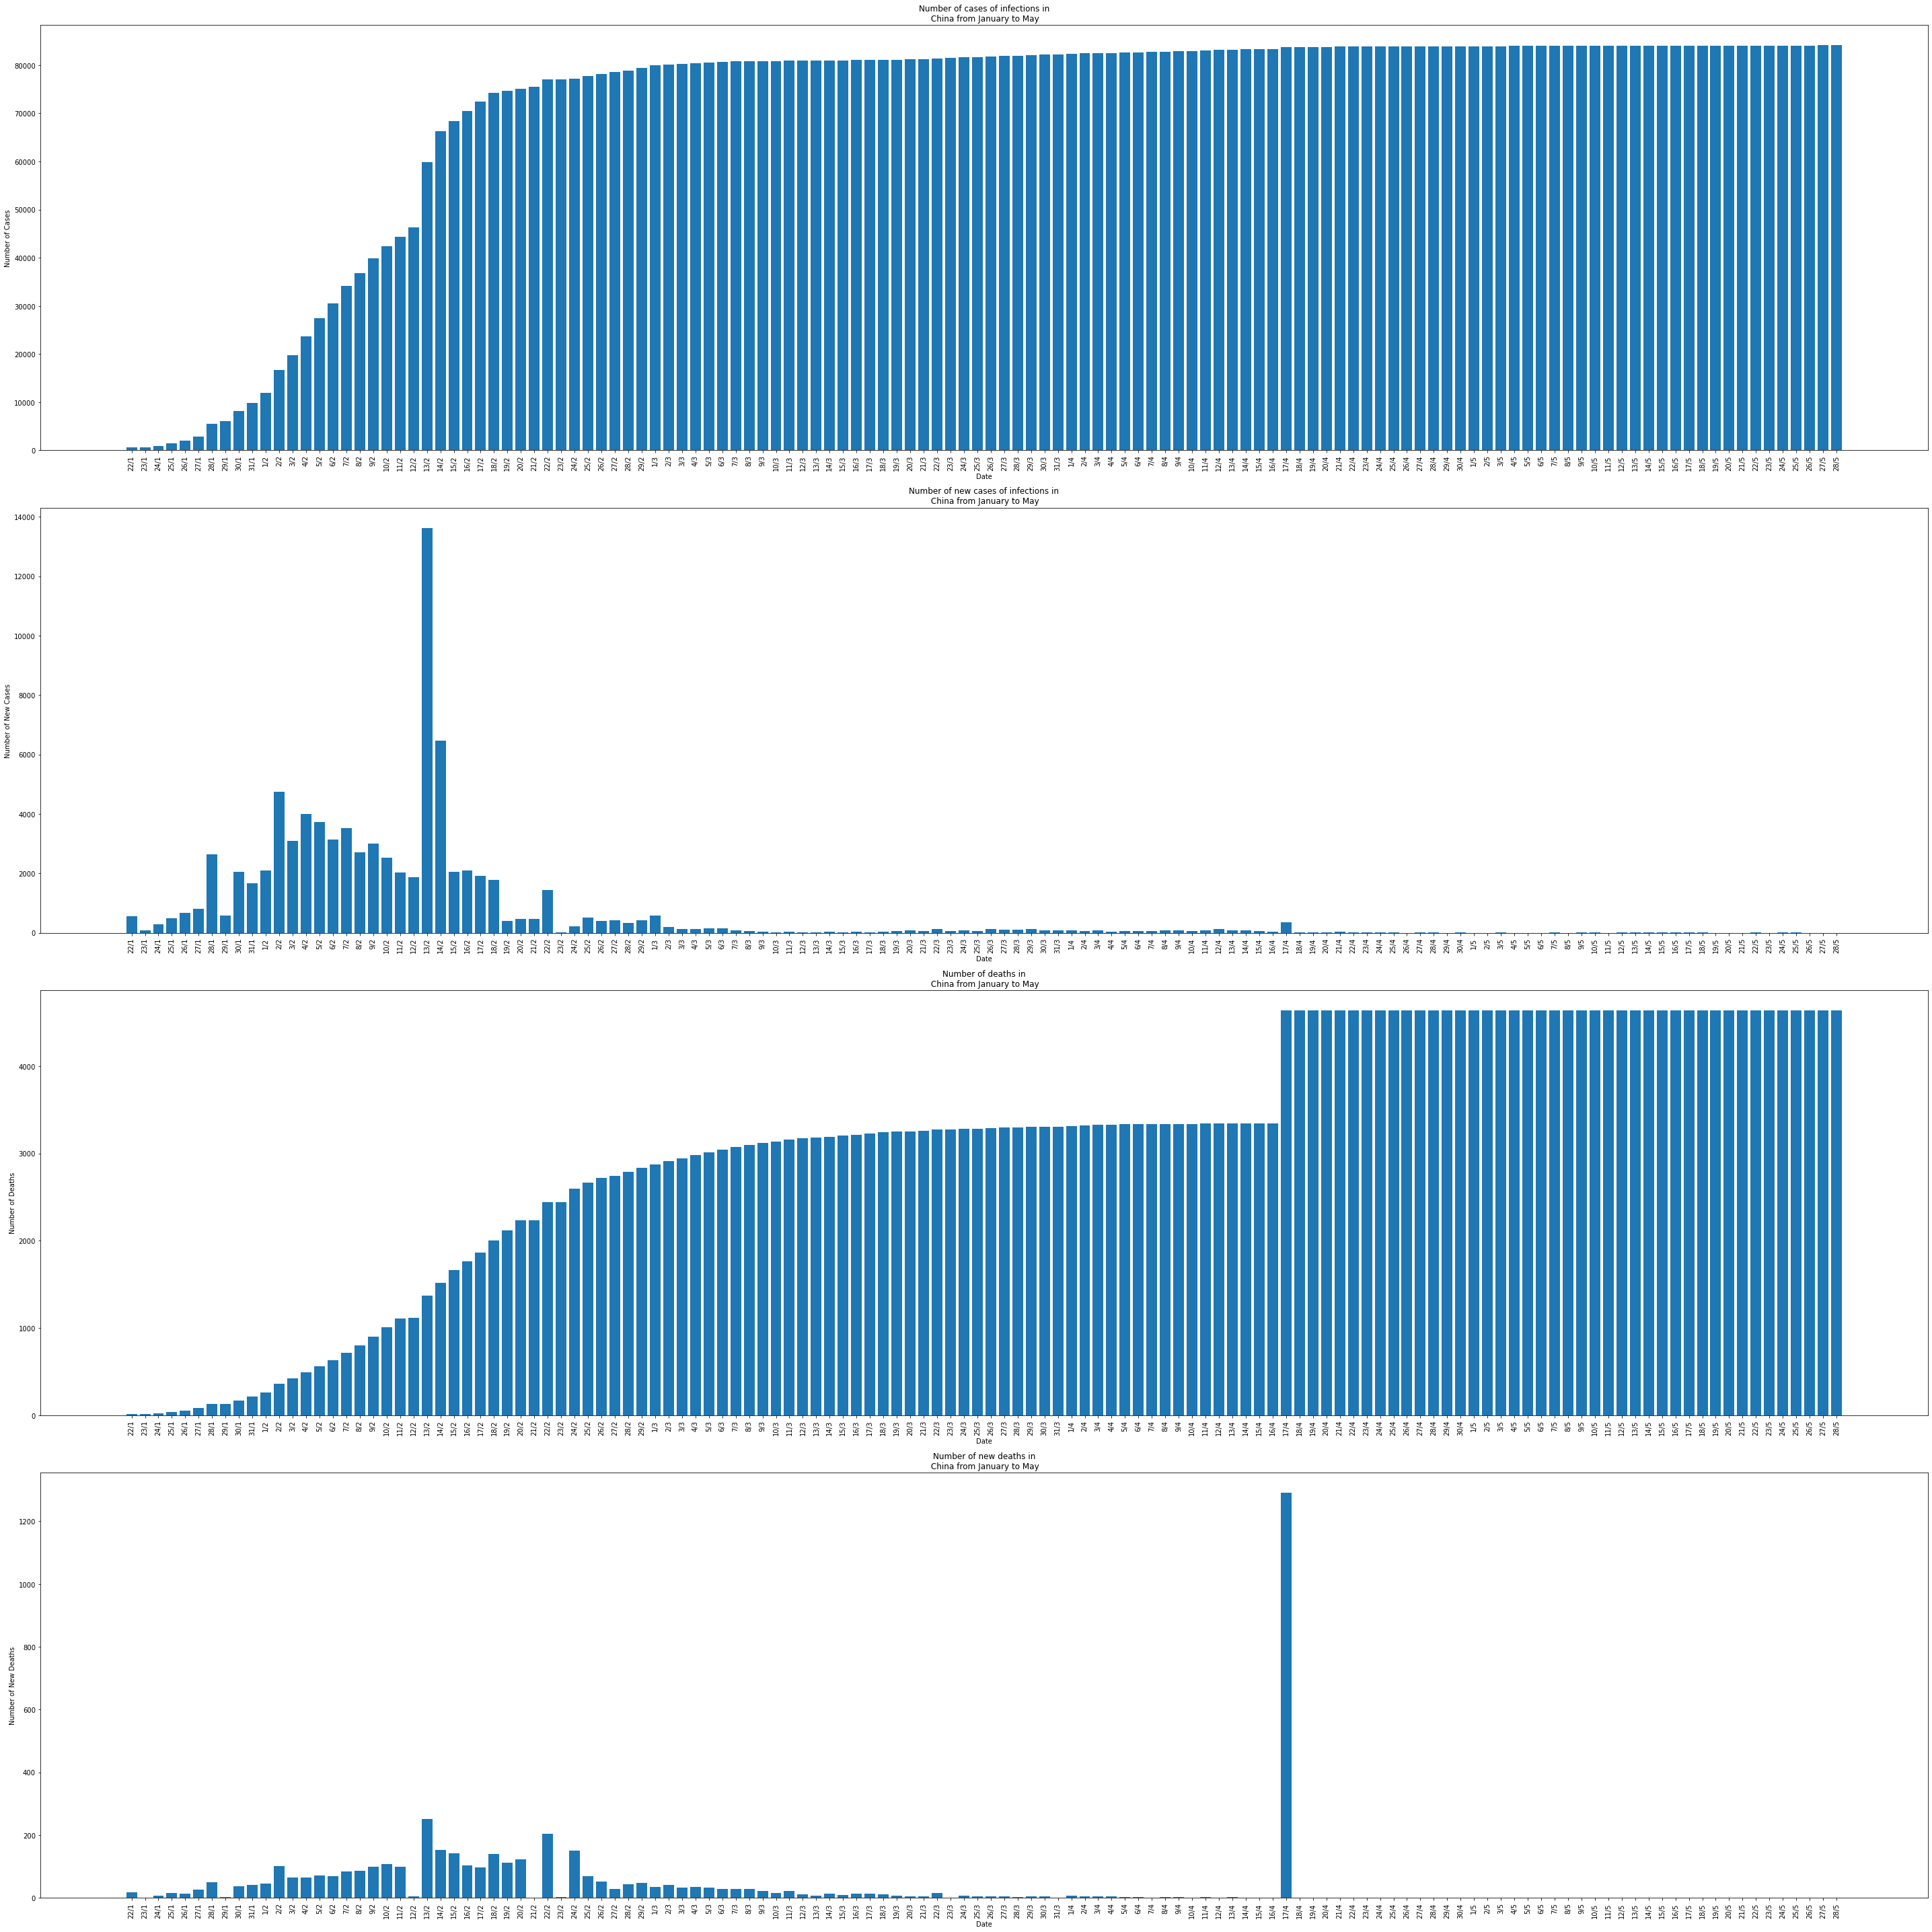

In [32]:
plot_total('China')

### Plotting graphs for South Korea

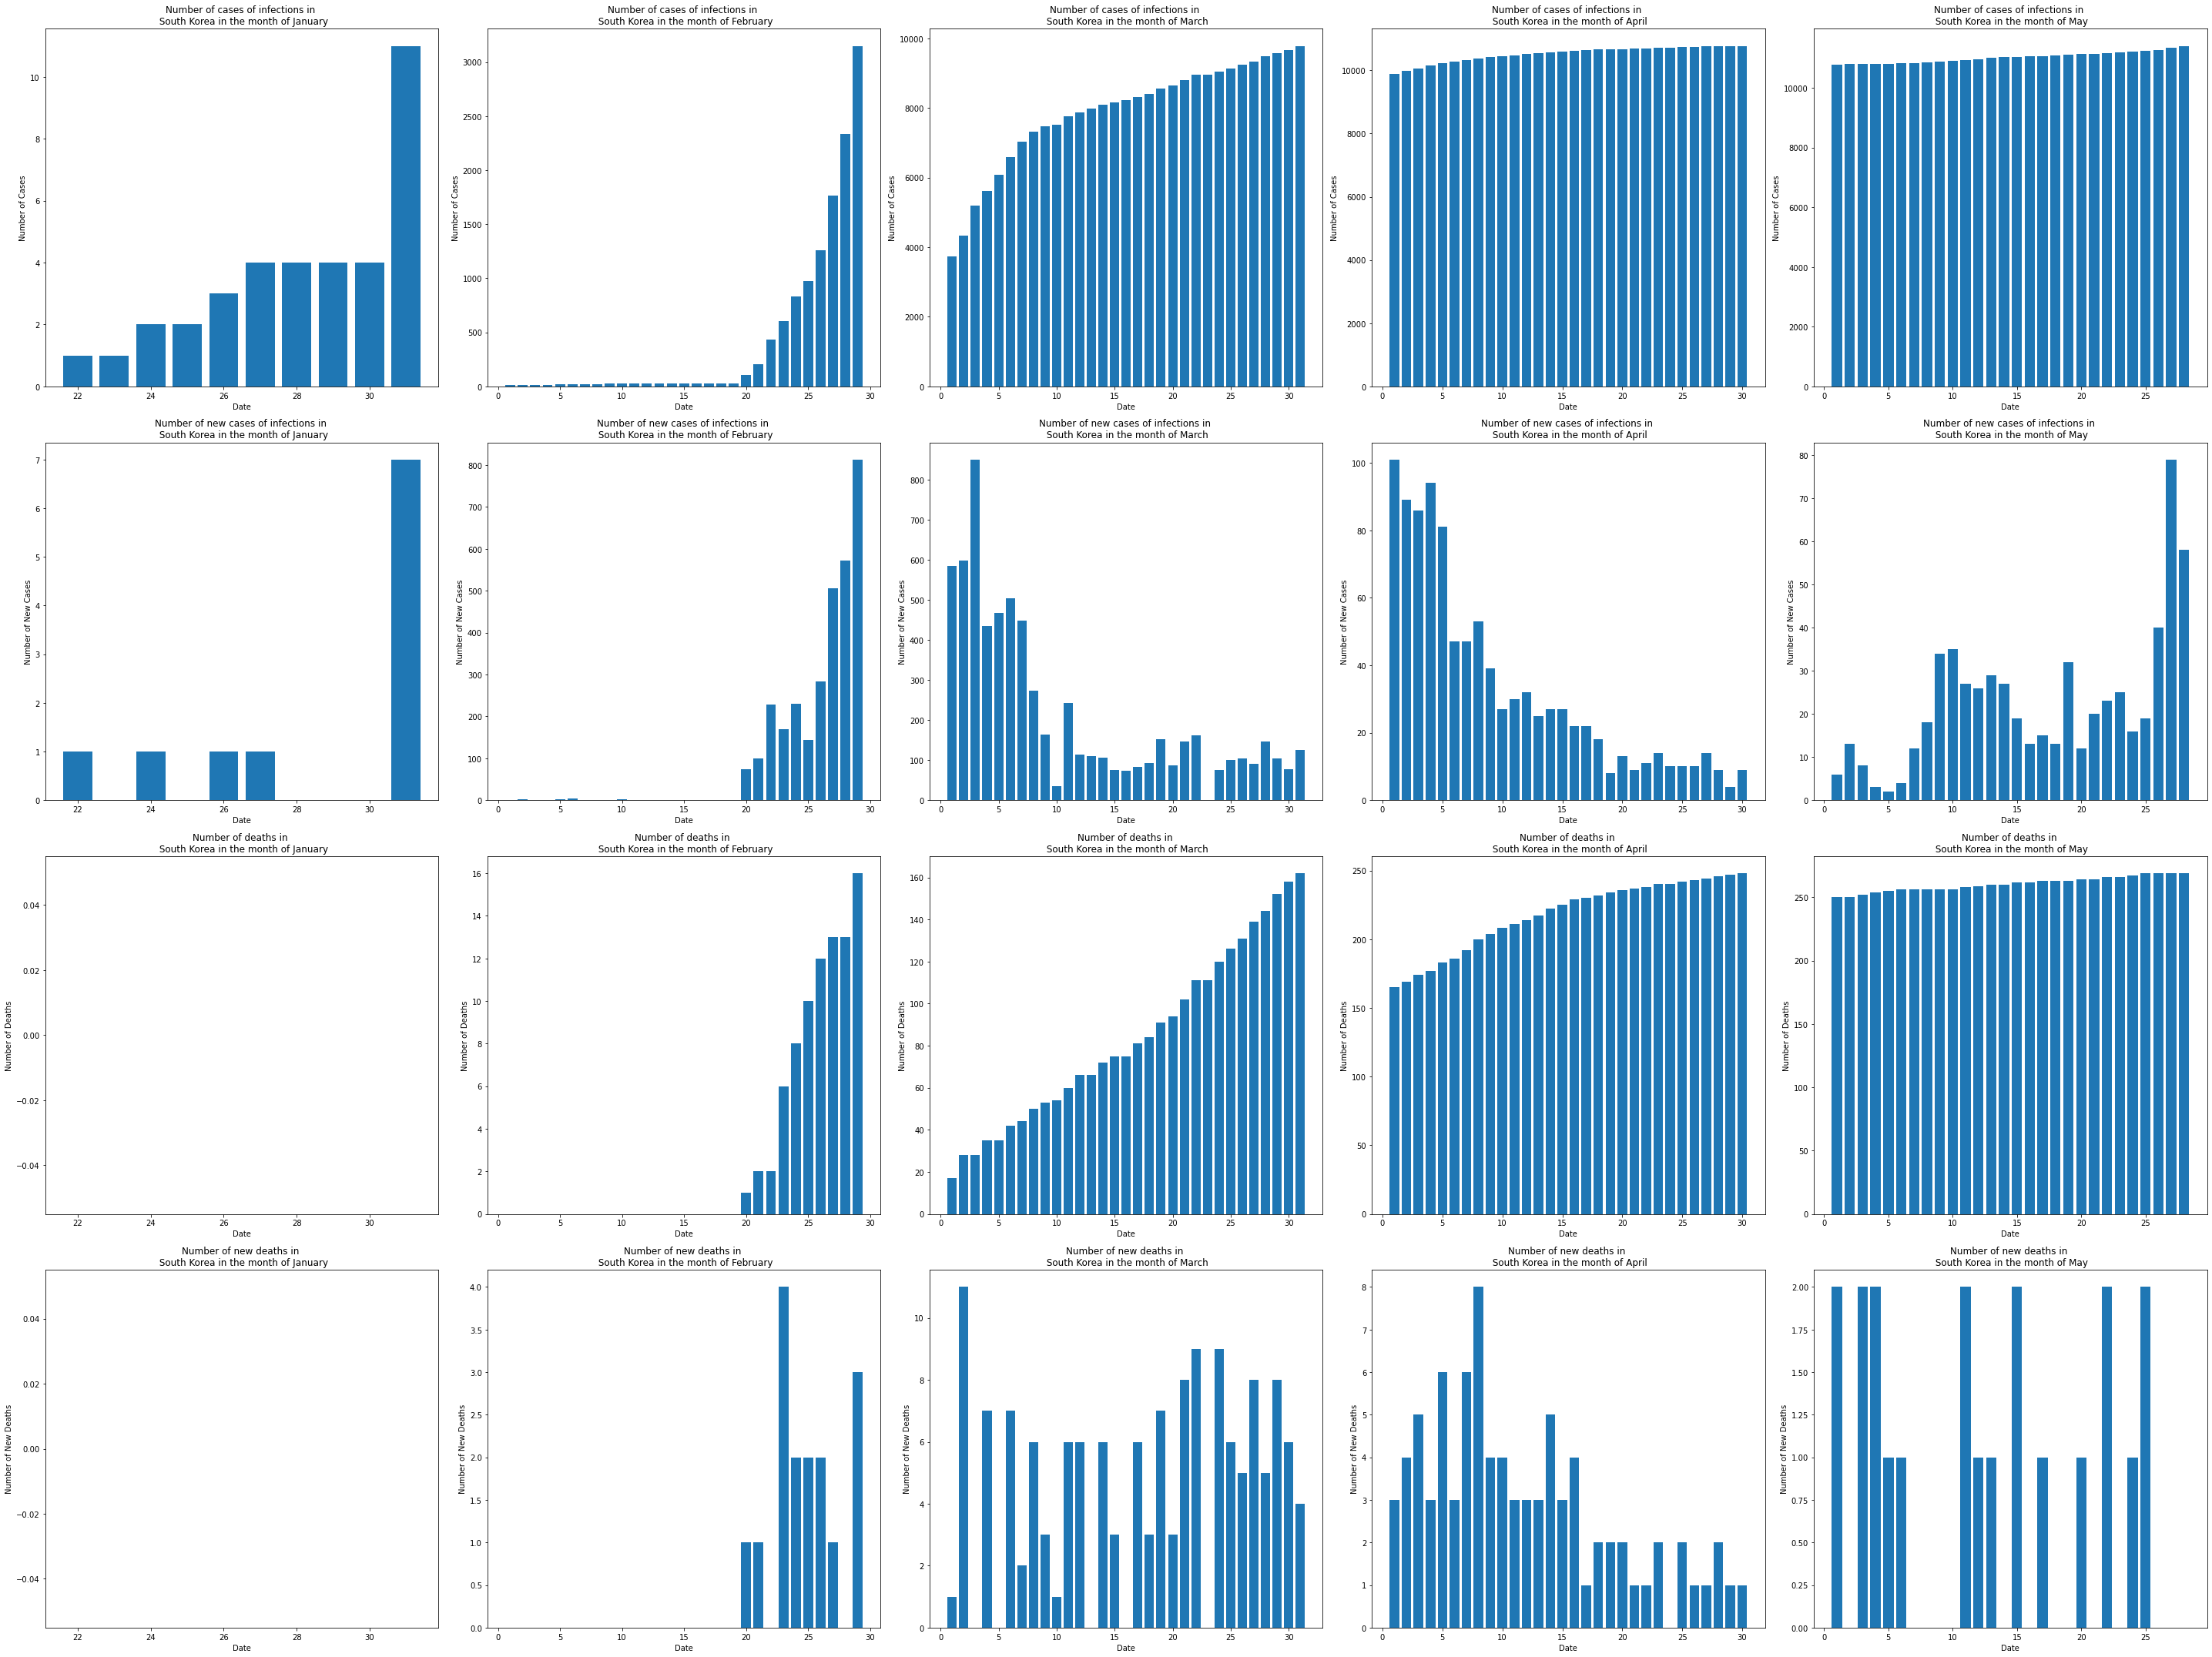

In [47]:
plot_monthwise('South Korea')

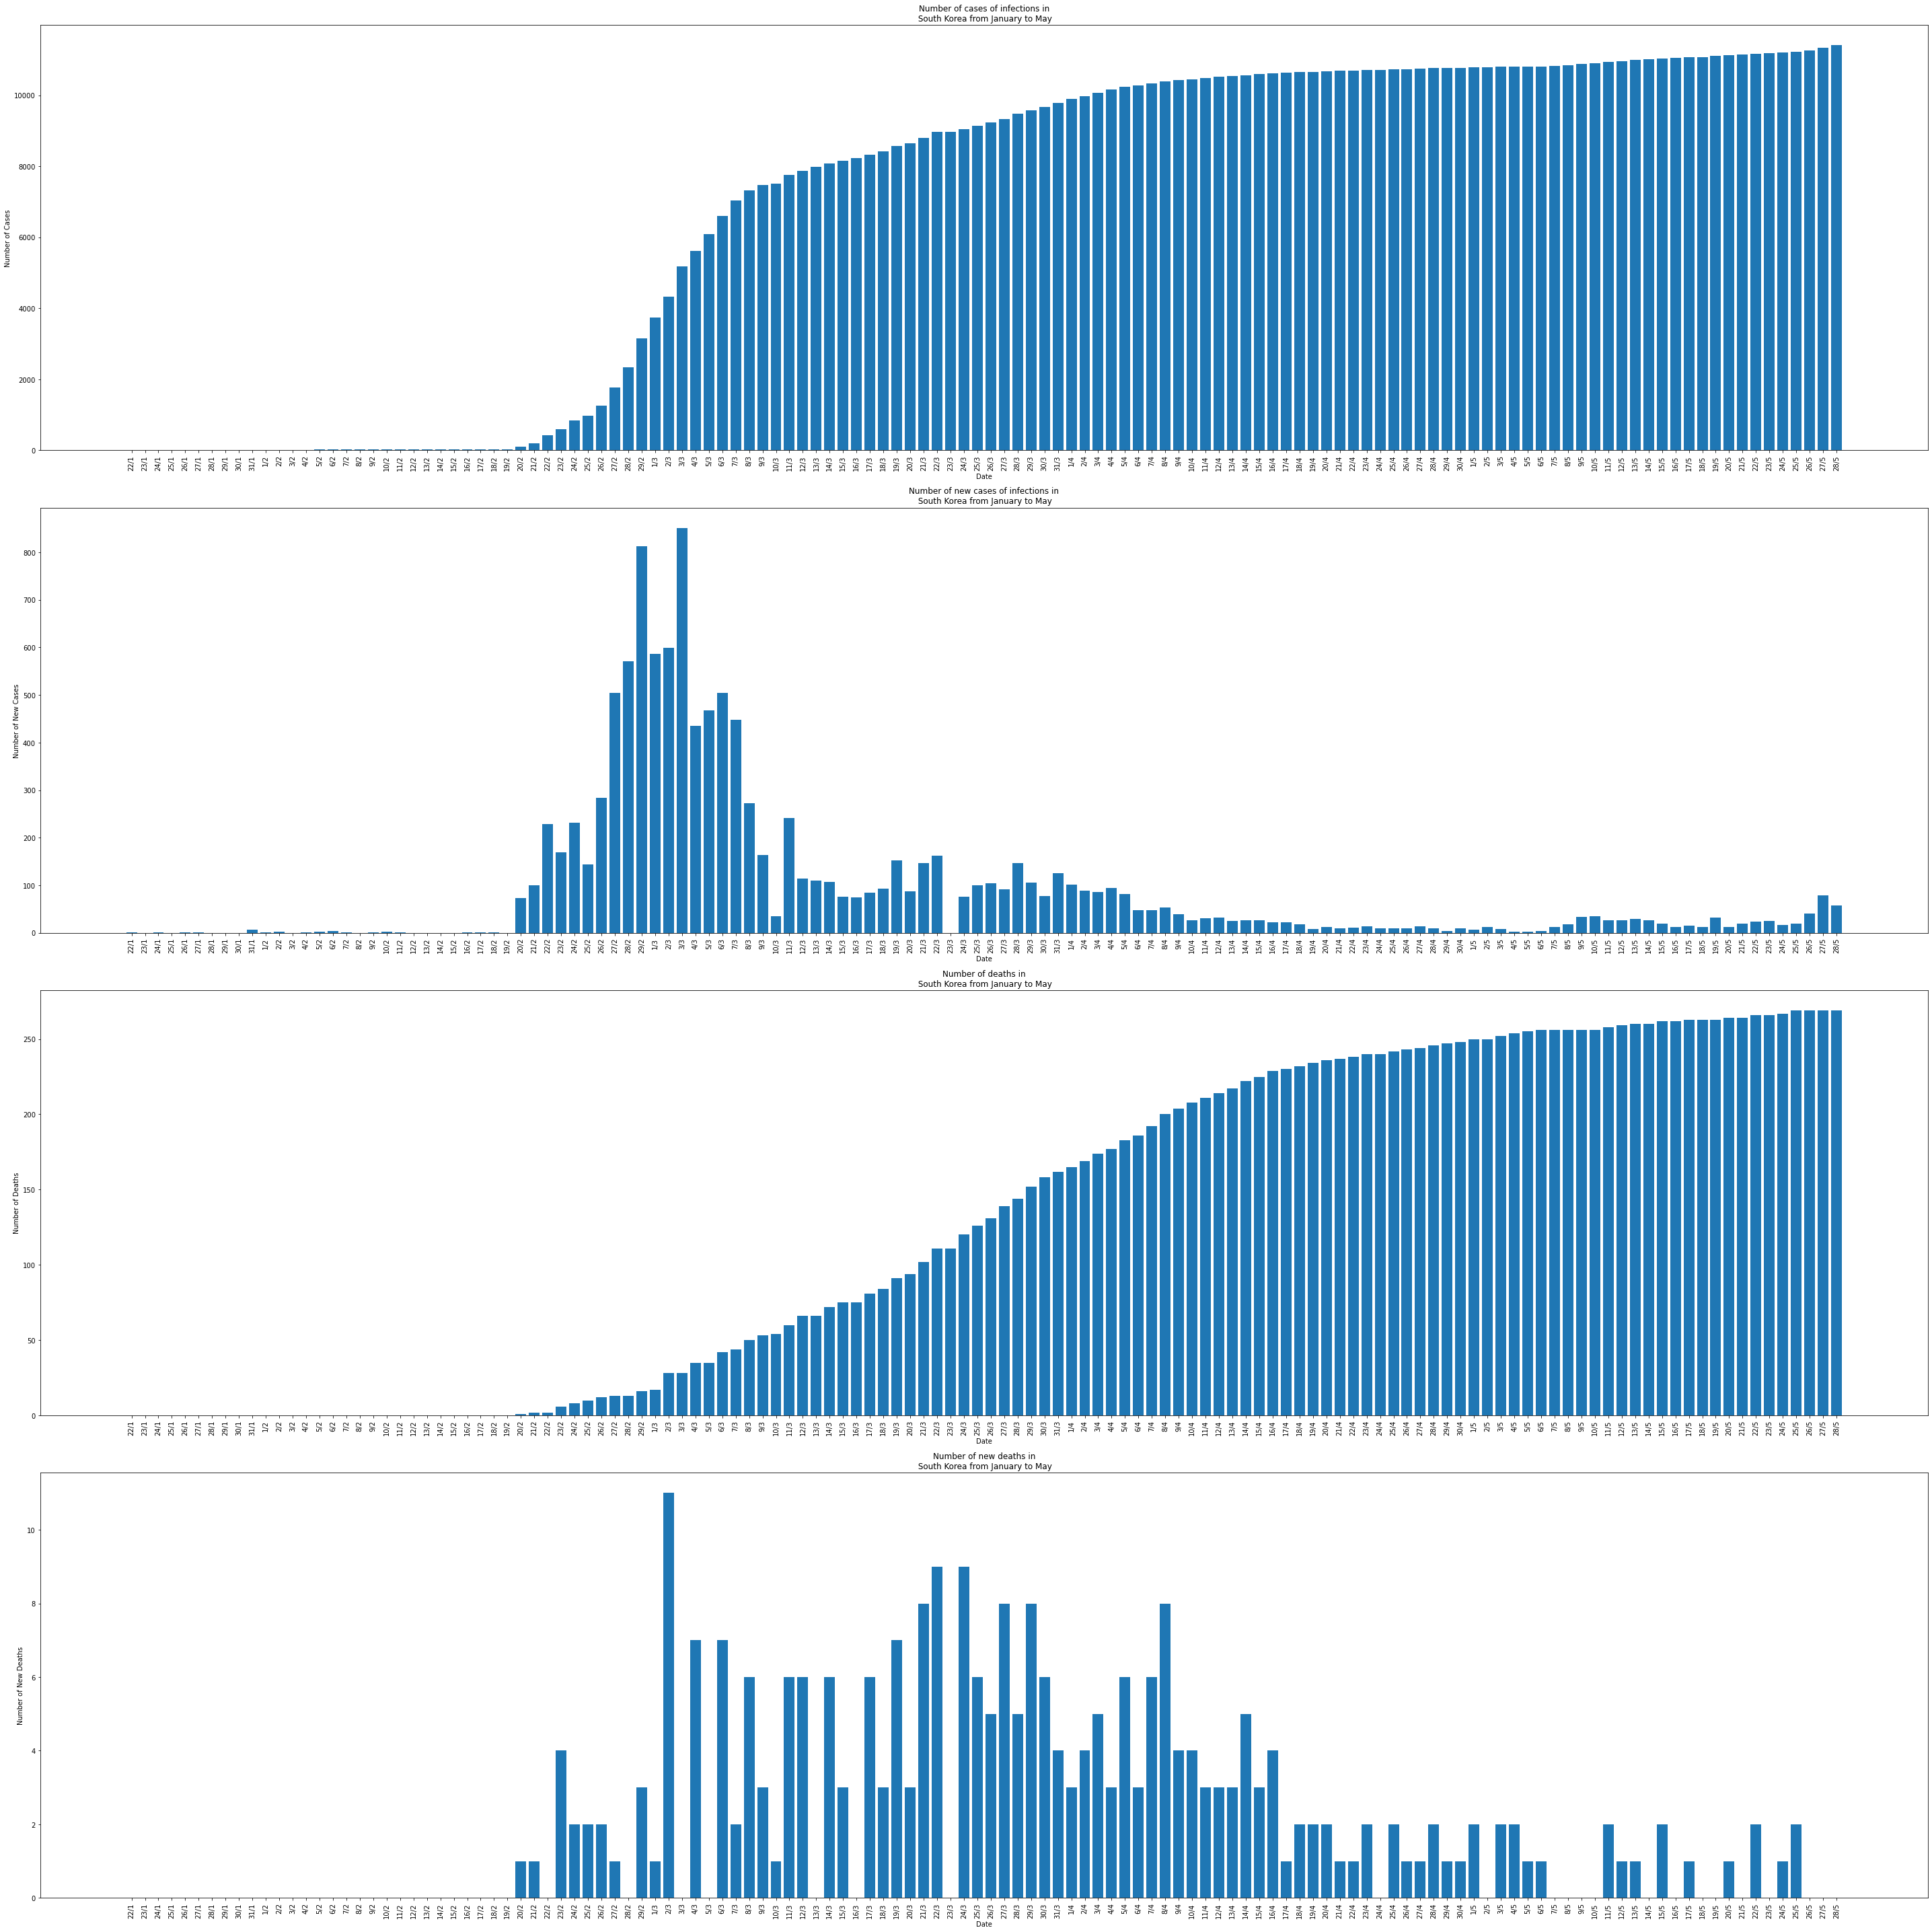

In [48]:
plot_total('South Korea')

### Plotting graphs for US

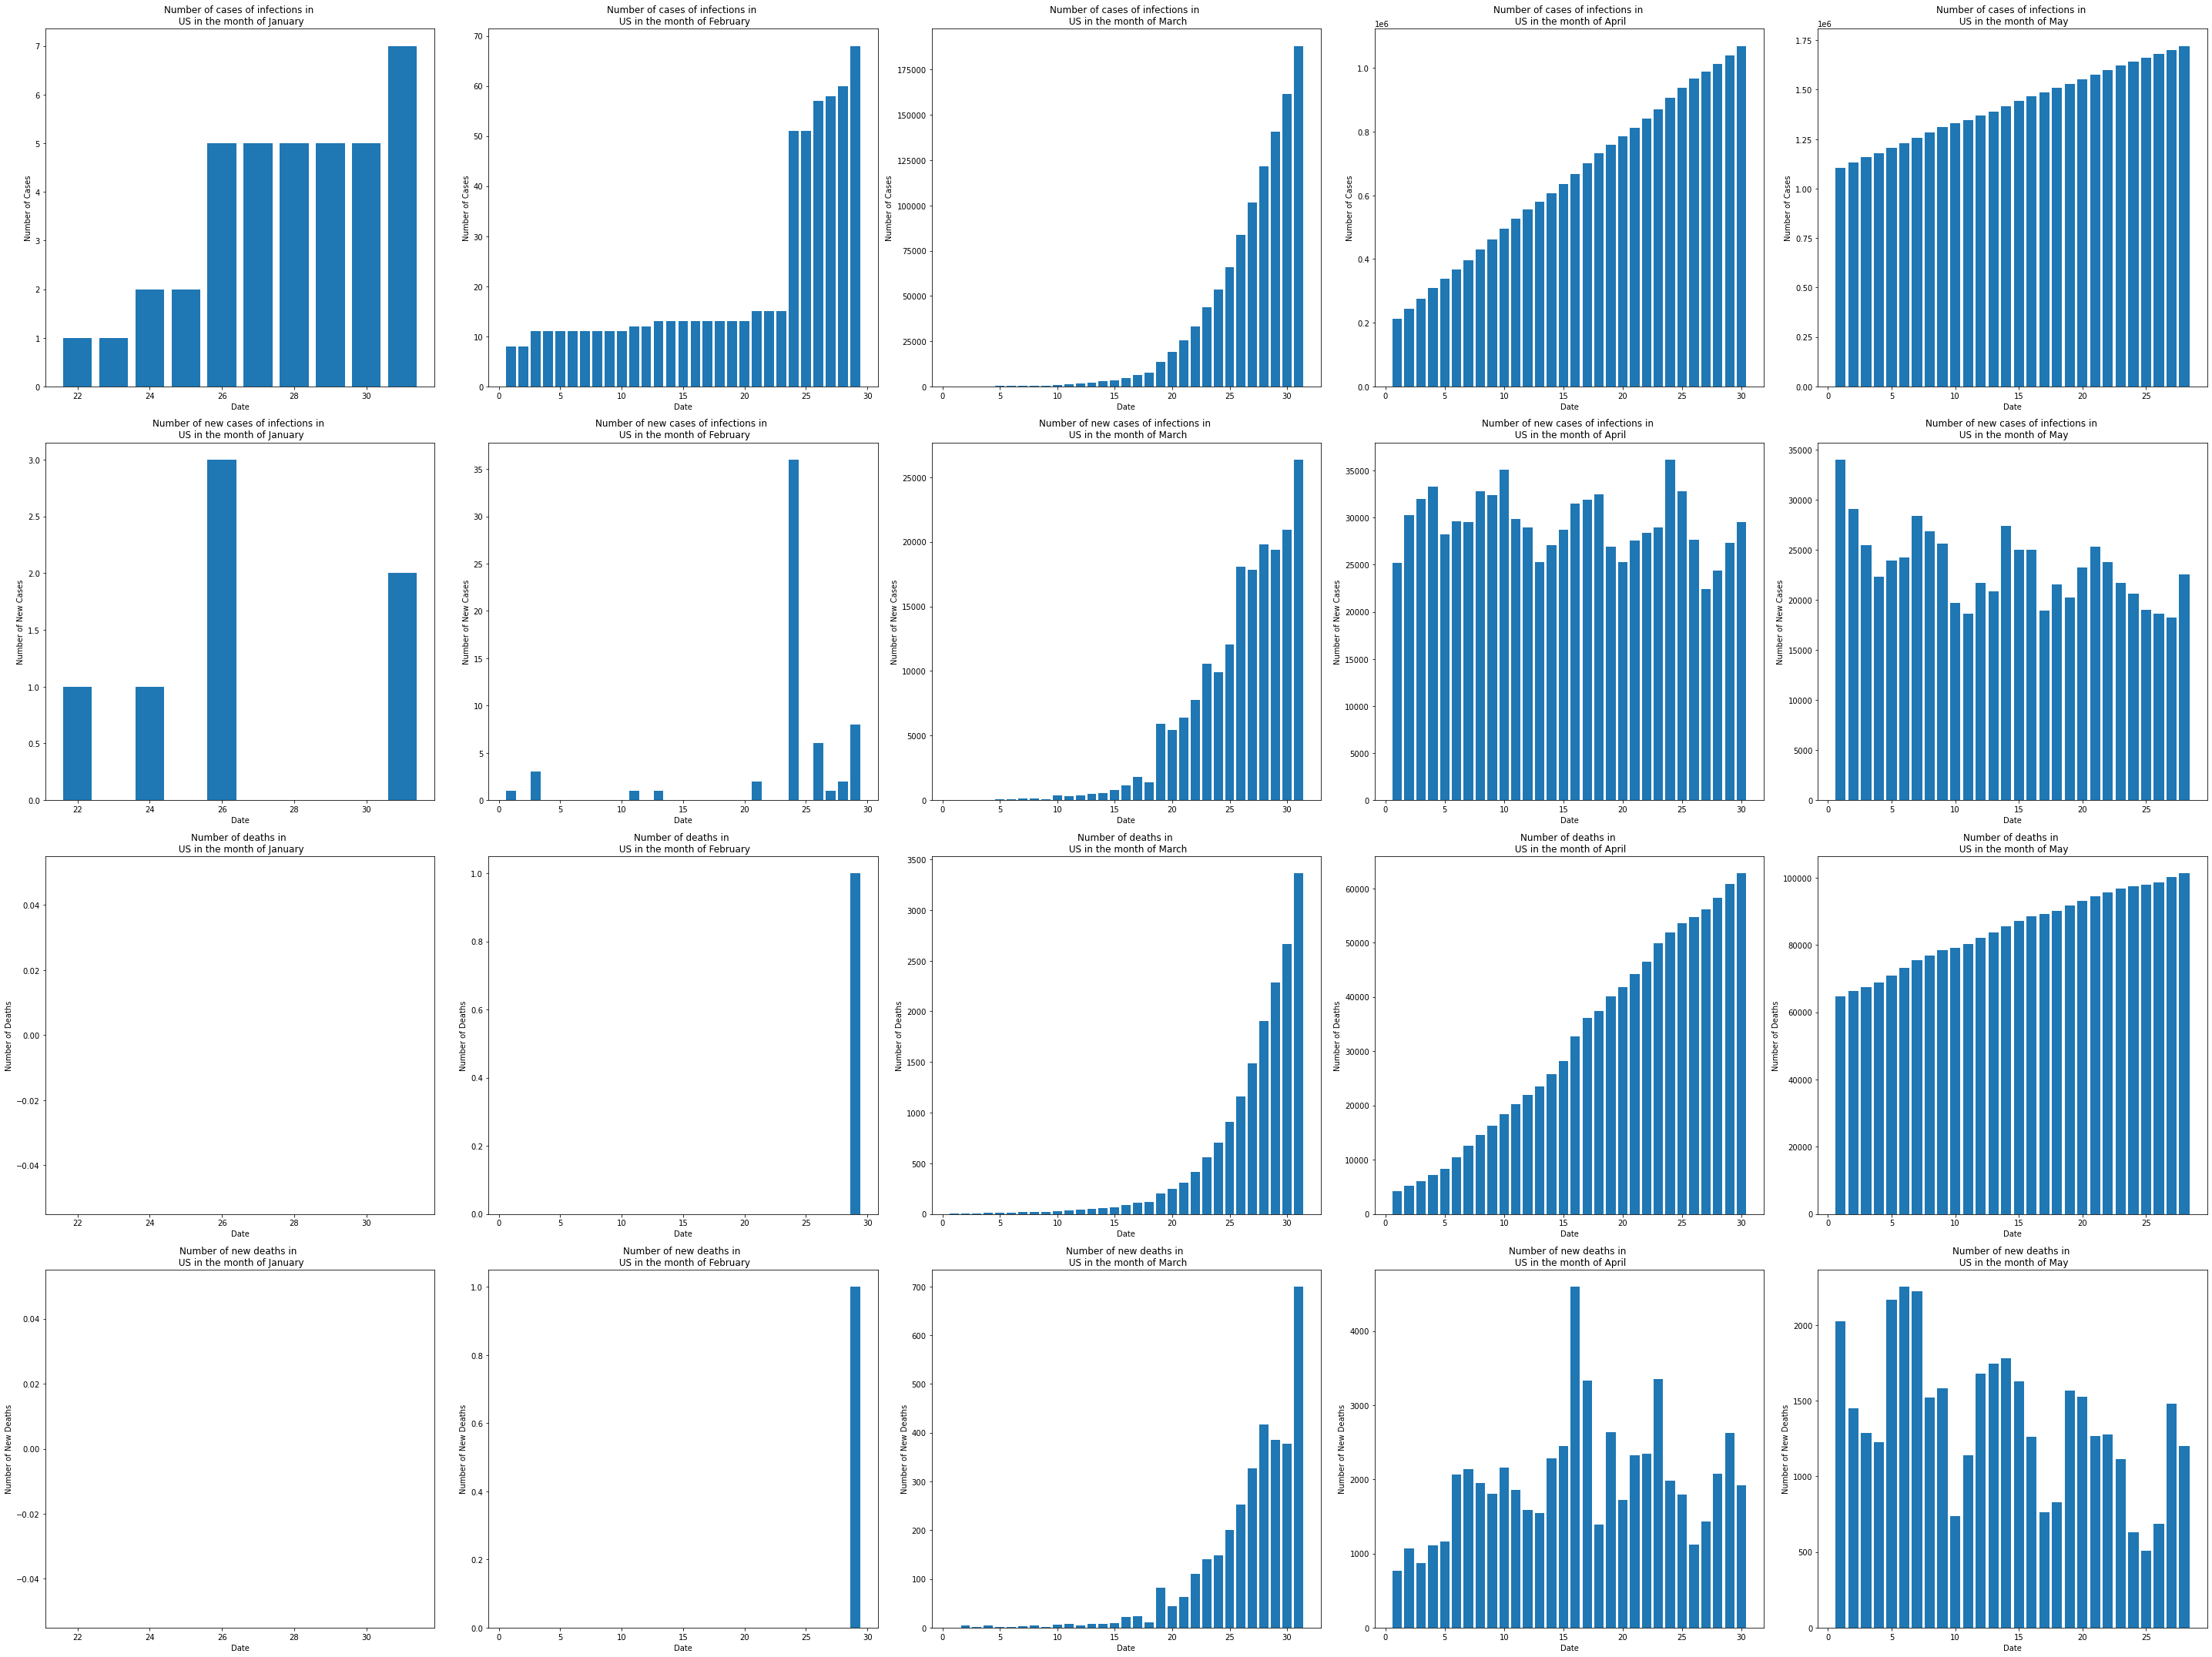

In [49]:
plot_monthwise('US')

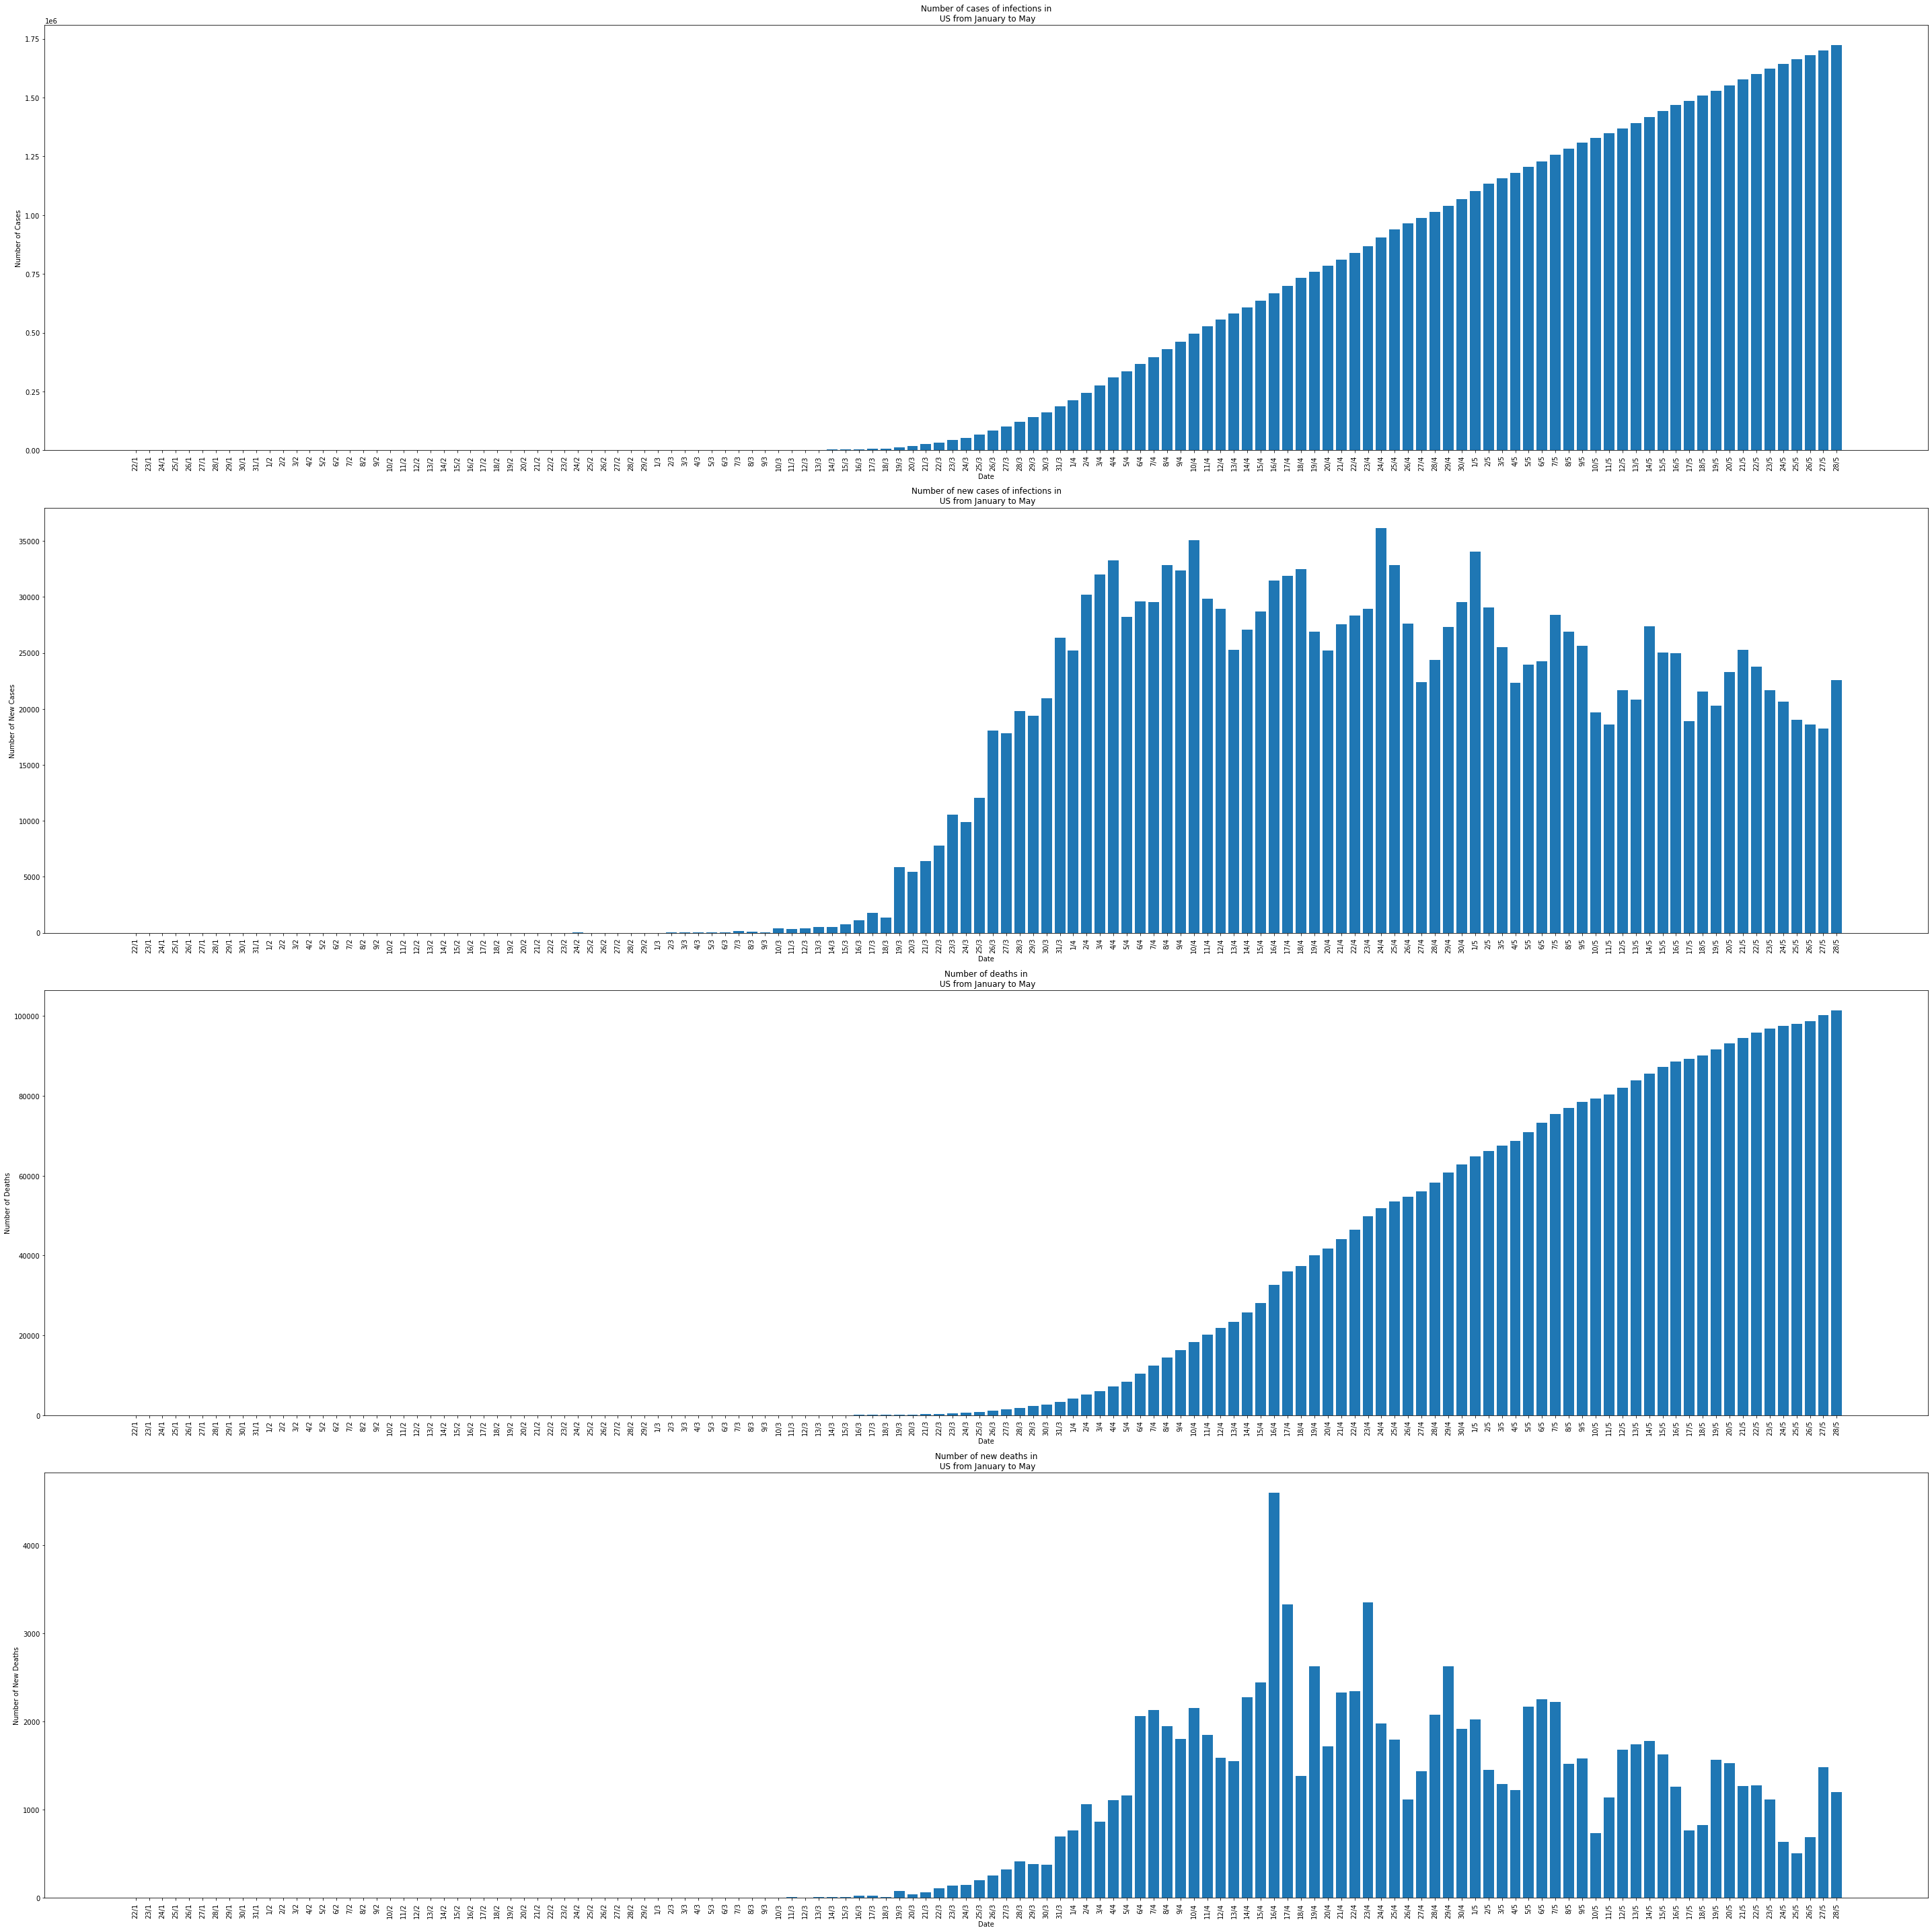

In [50]:
plot_total('US')

### Plotting graphs for Italy


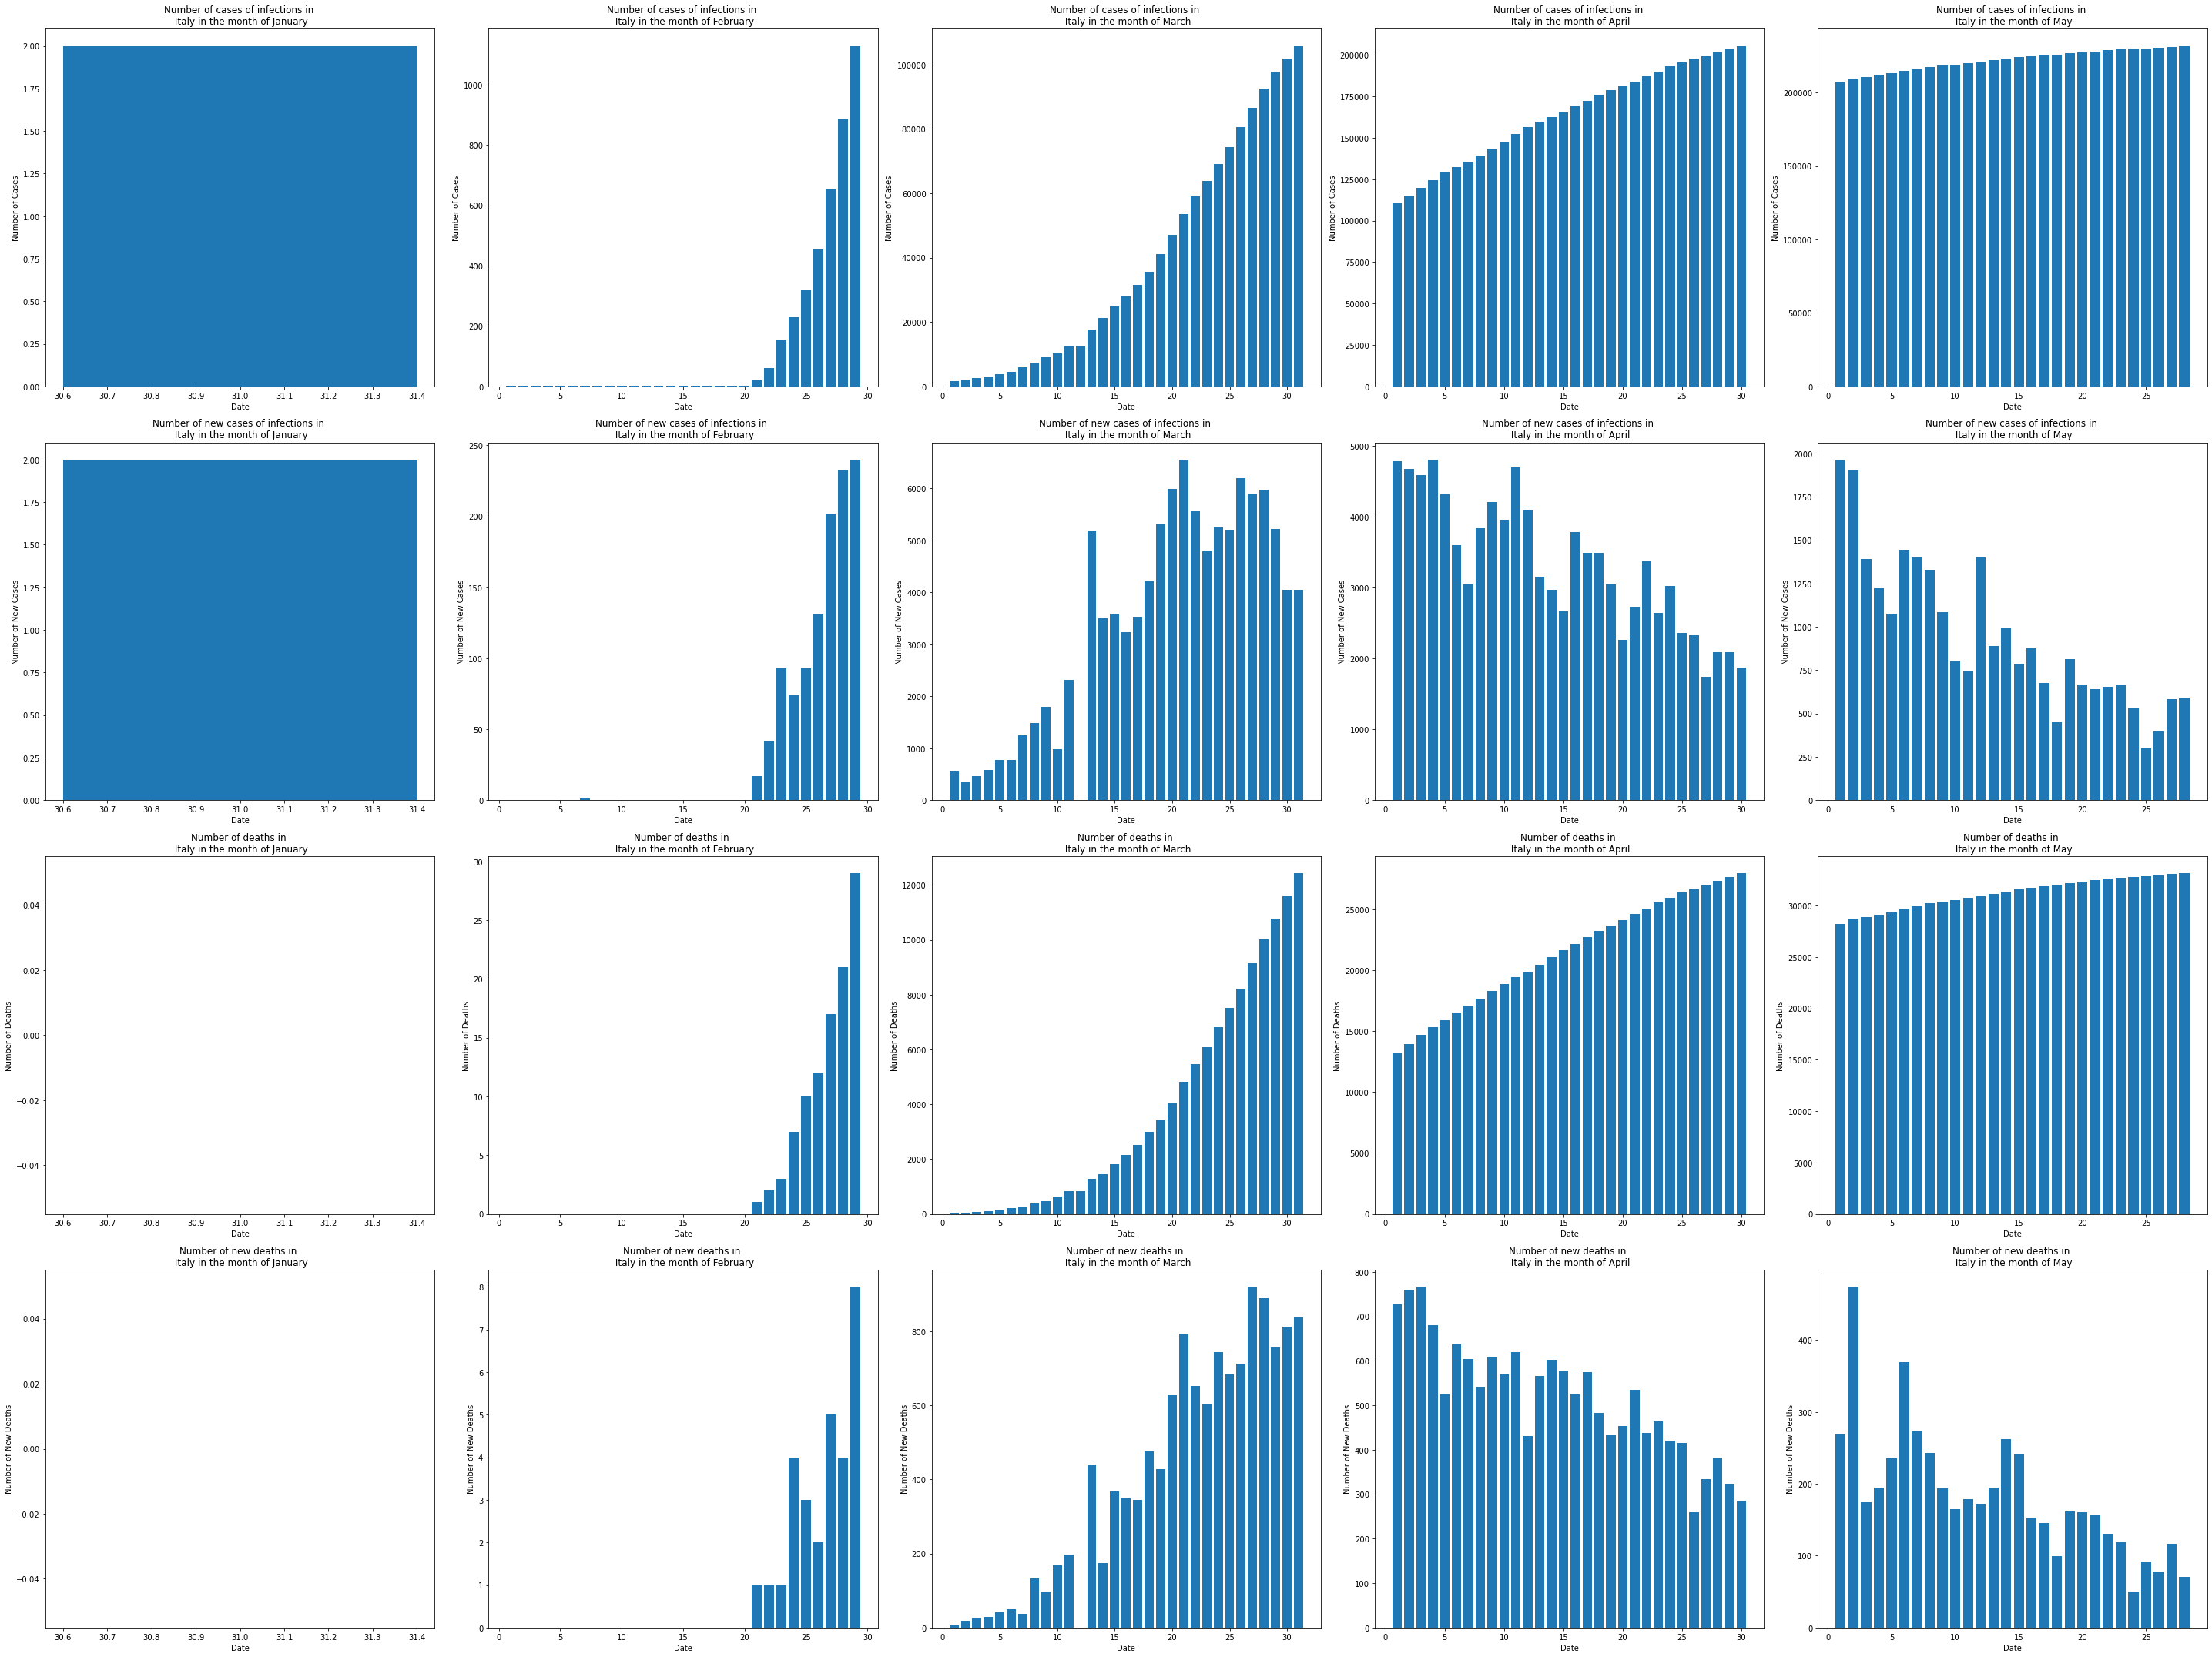

In [59]:
plot_monthwise('Italy')

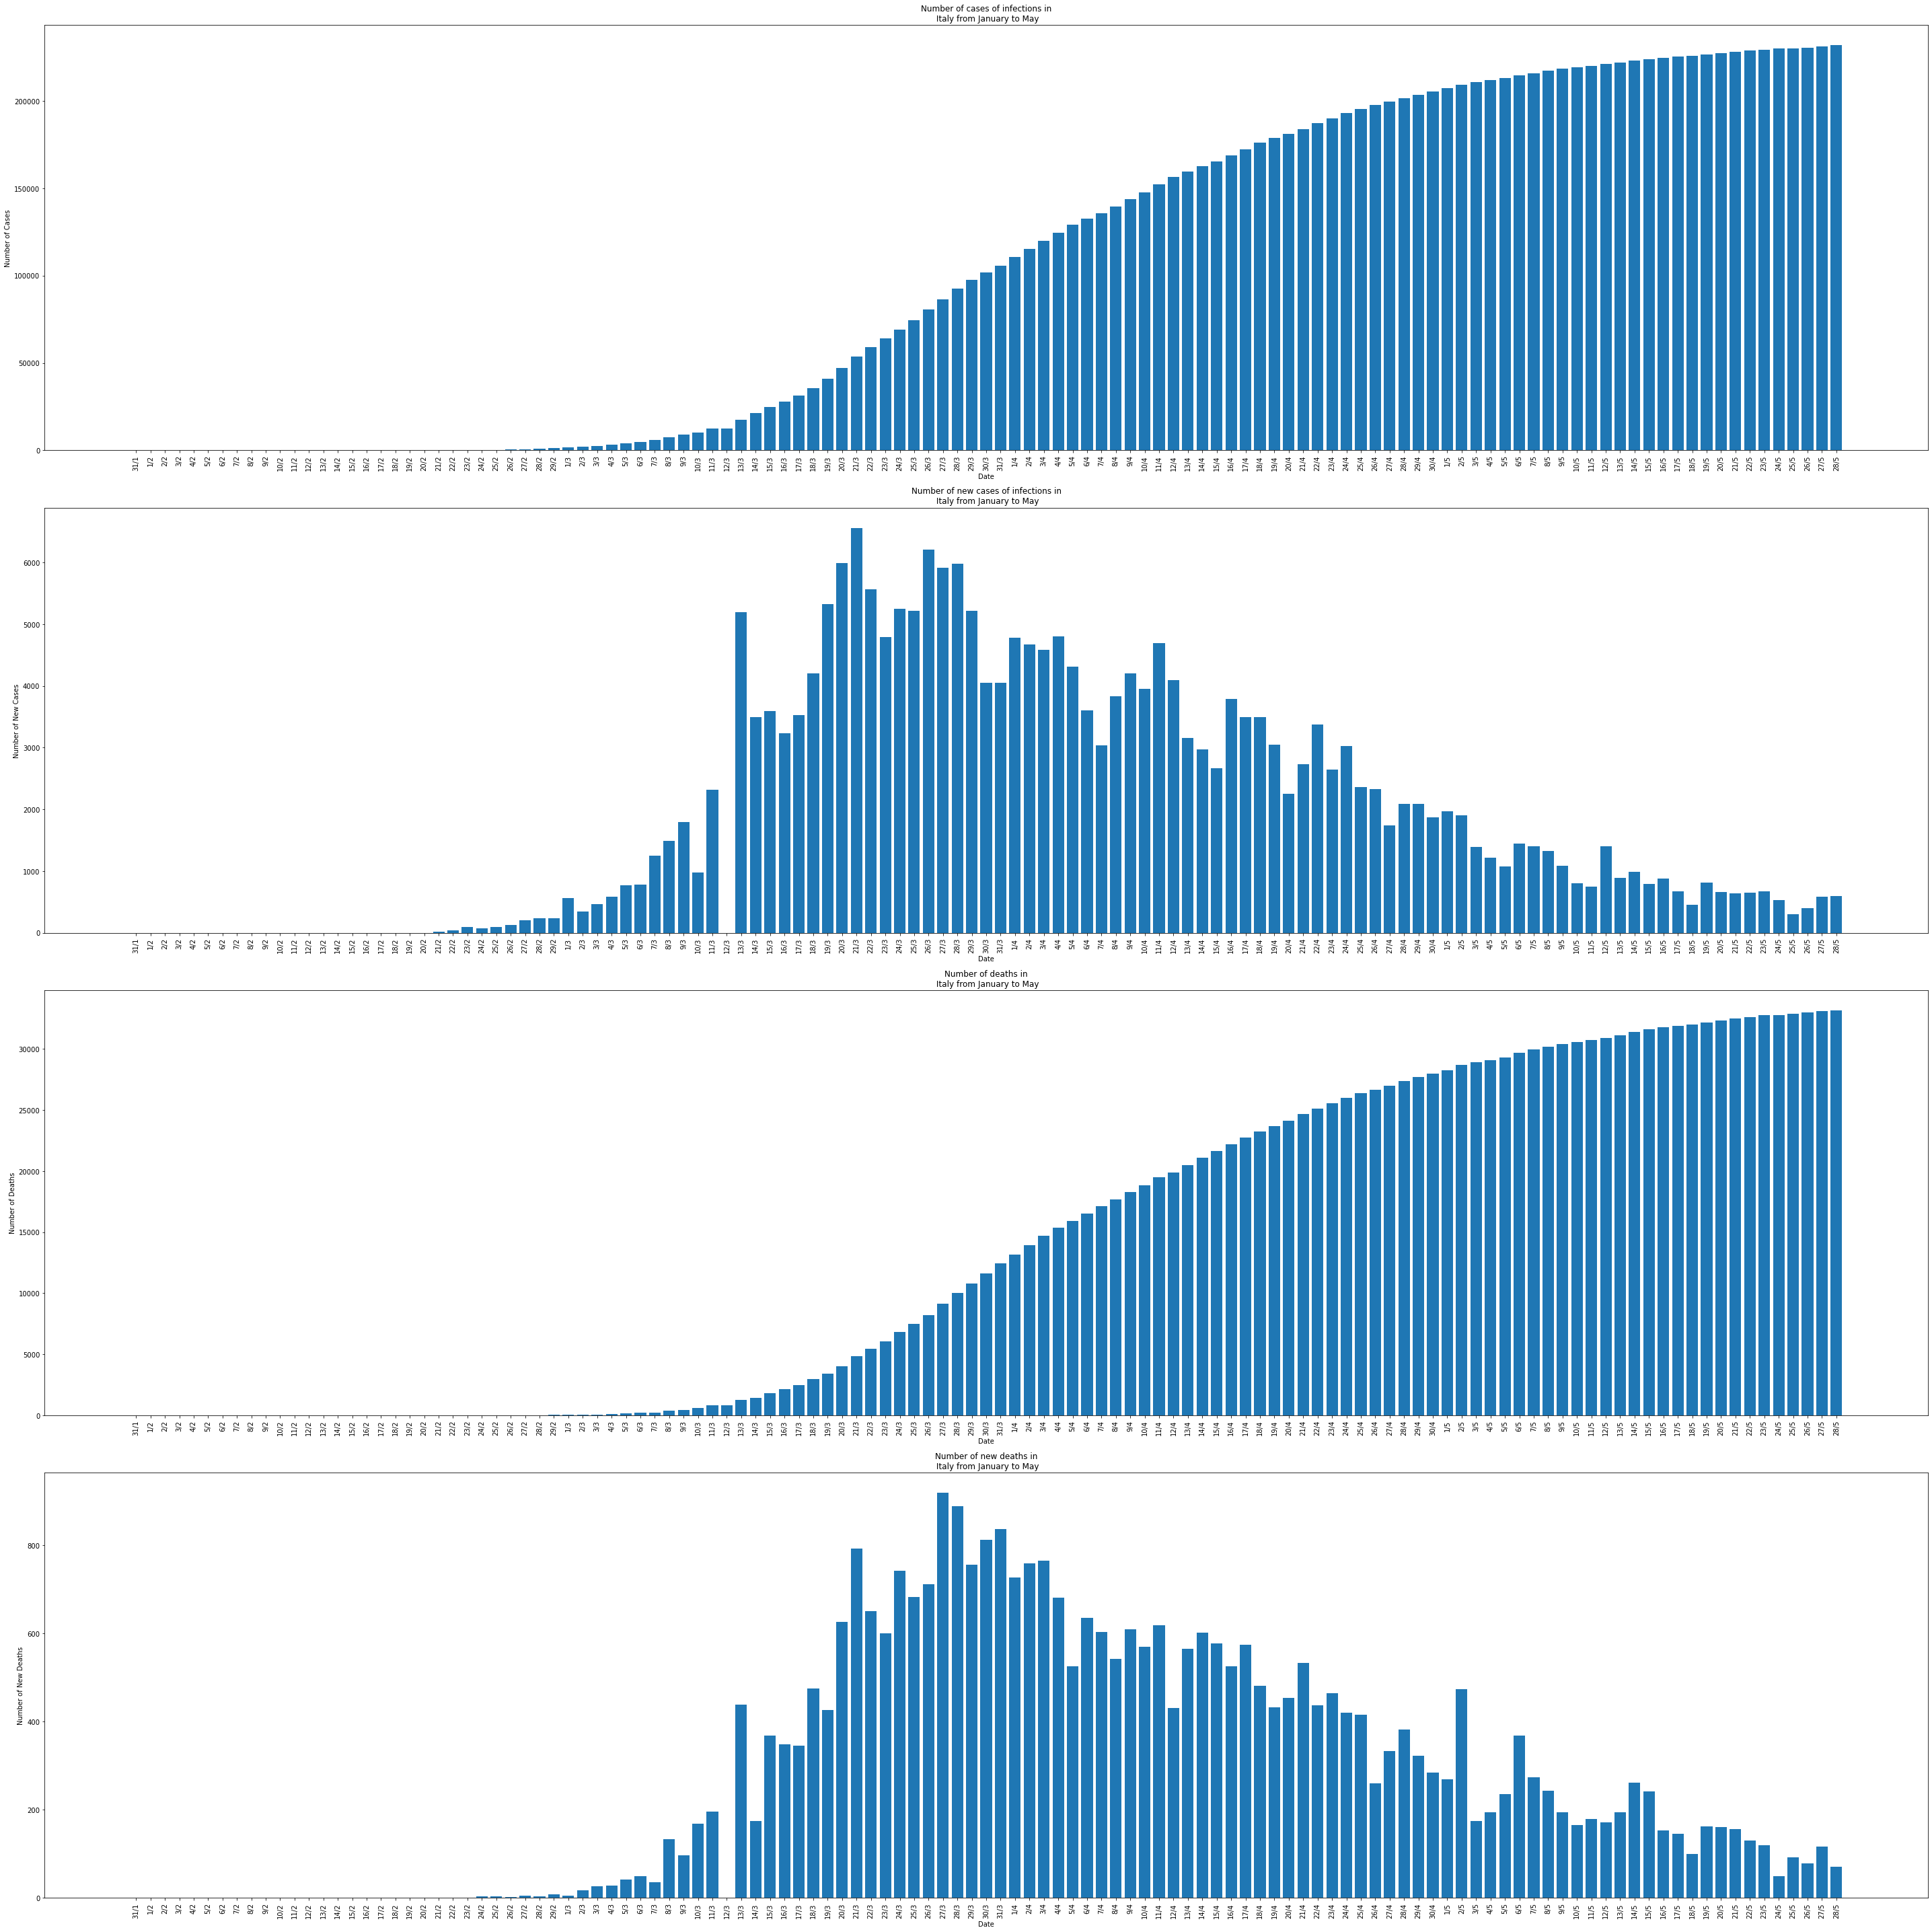

In [60]:
plot_total('Italy')

### Plotting graphs for Spain

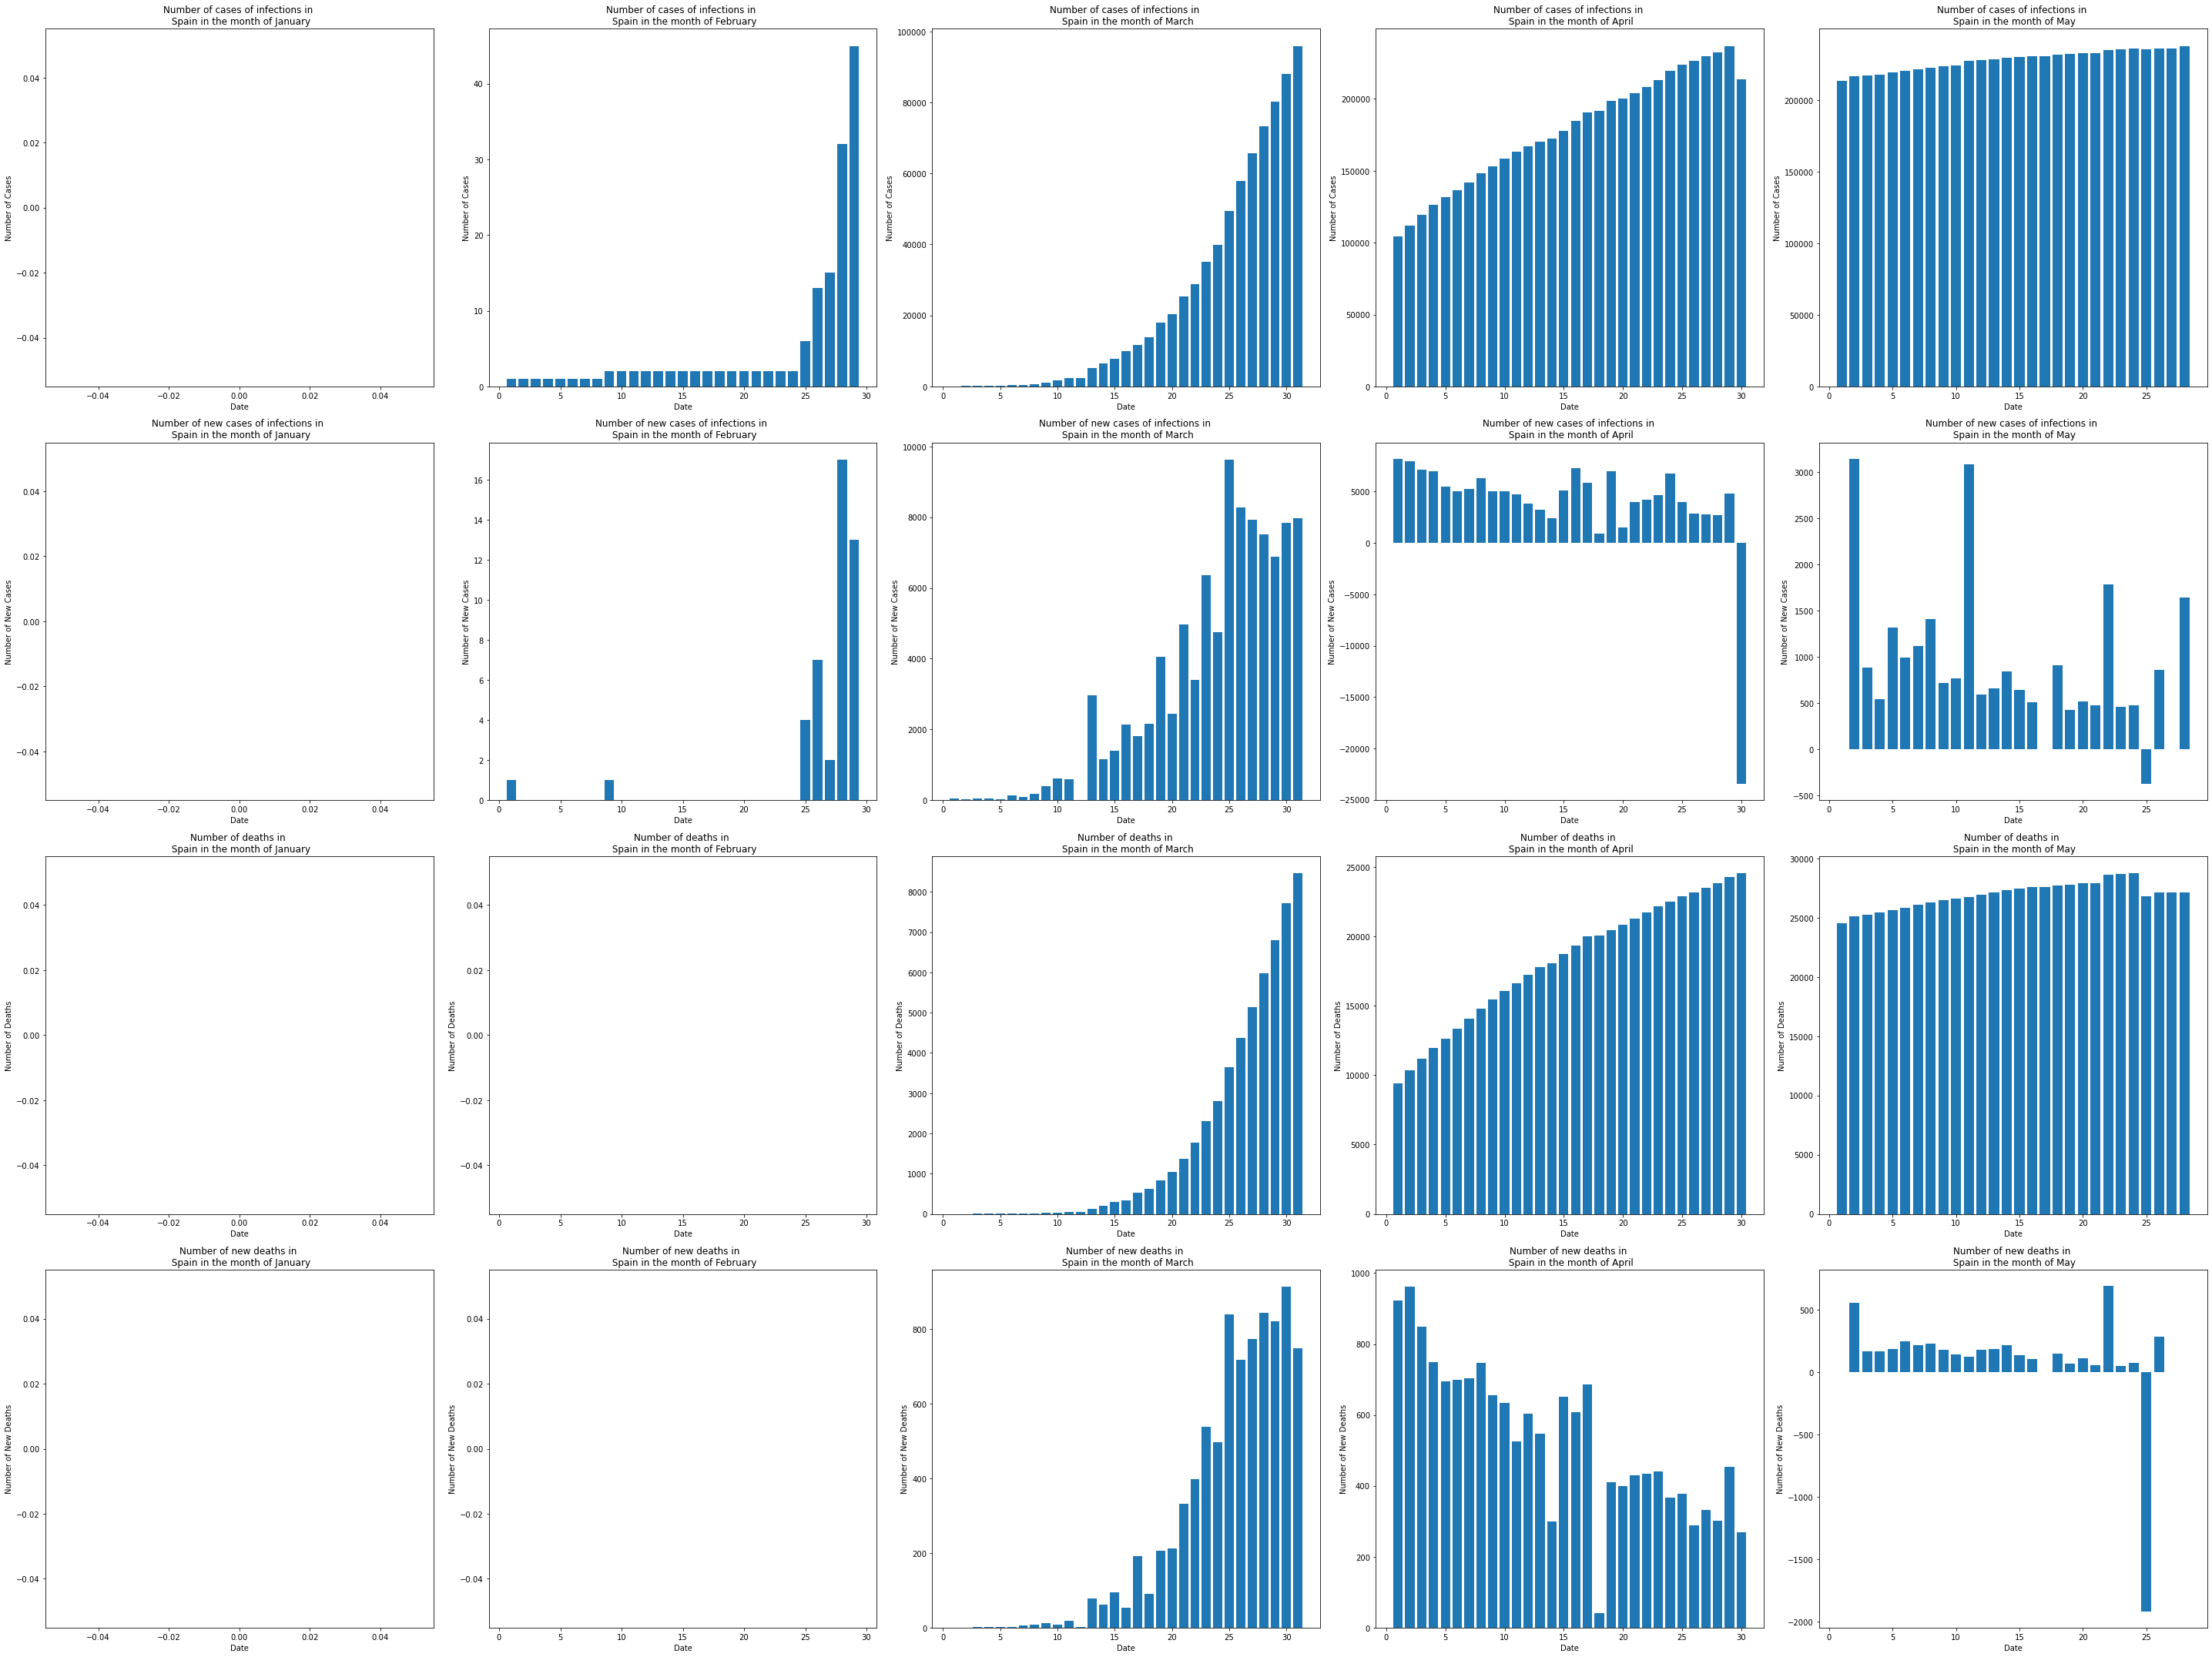

In [61]:
plot_monthwise('Spain')

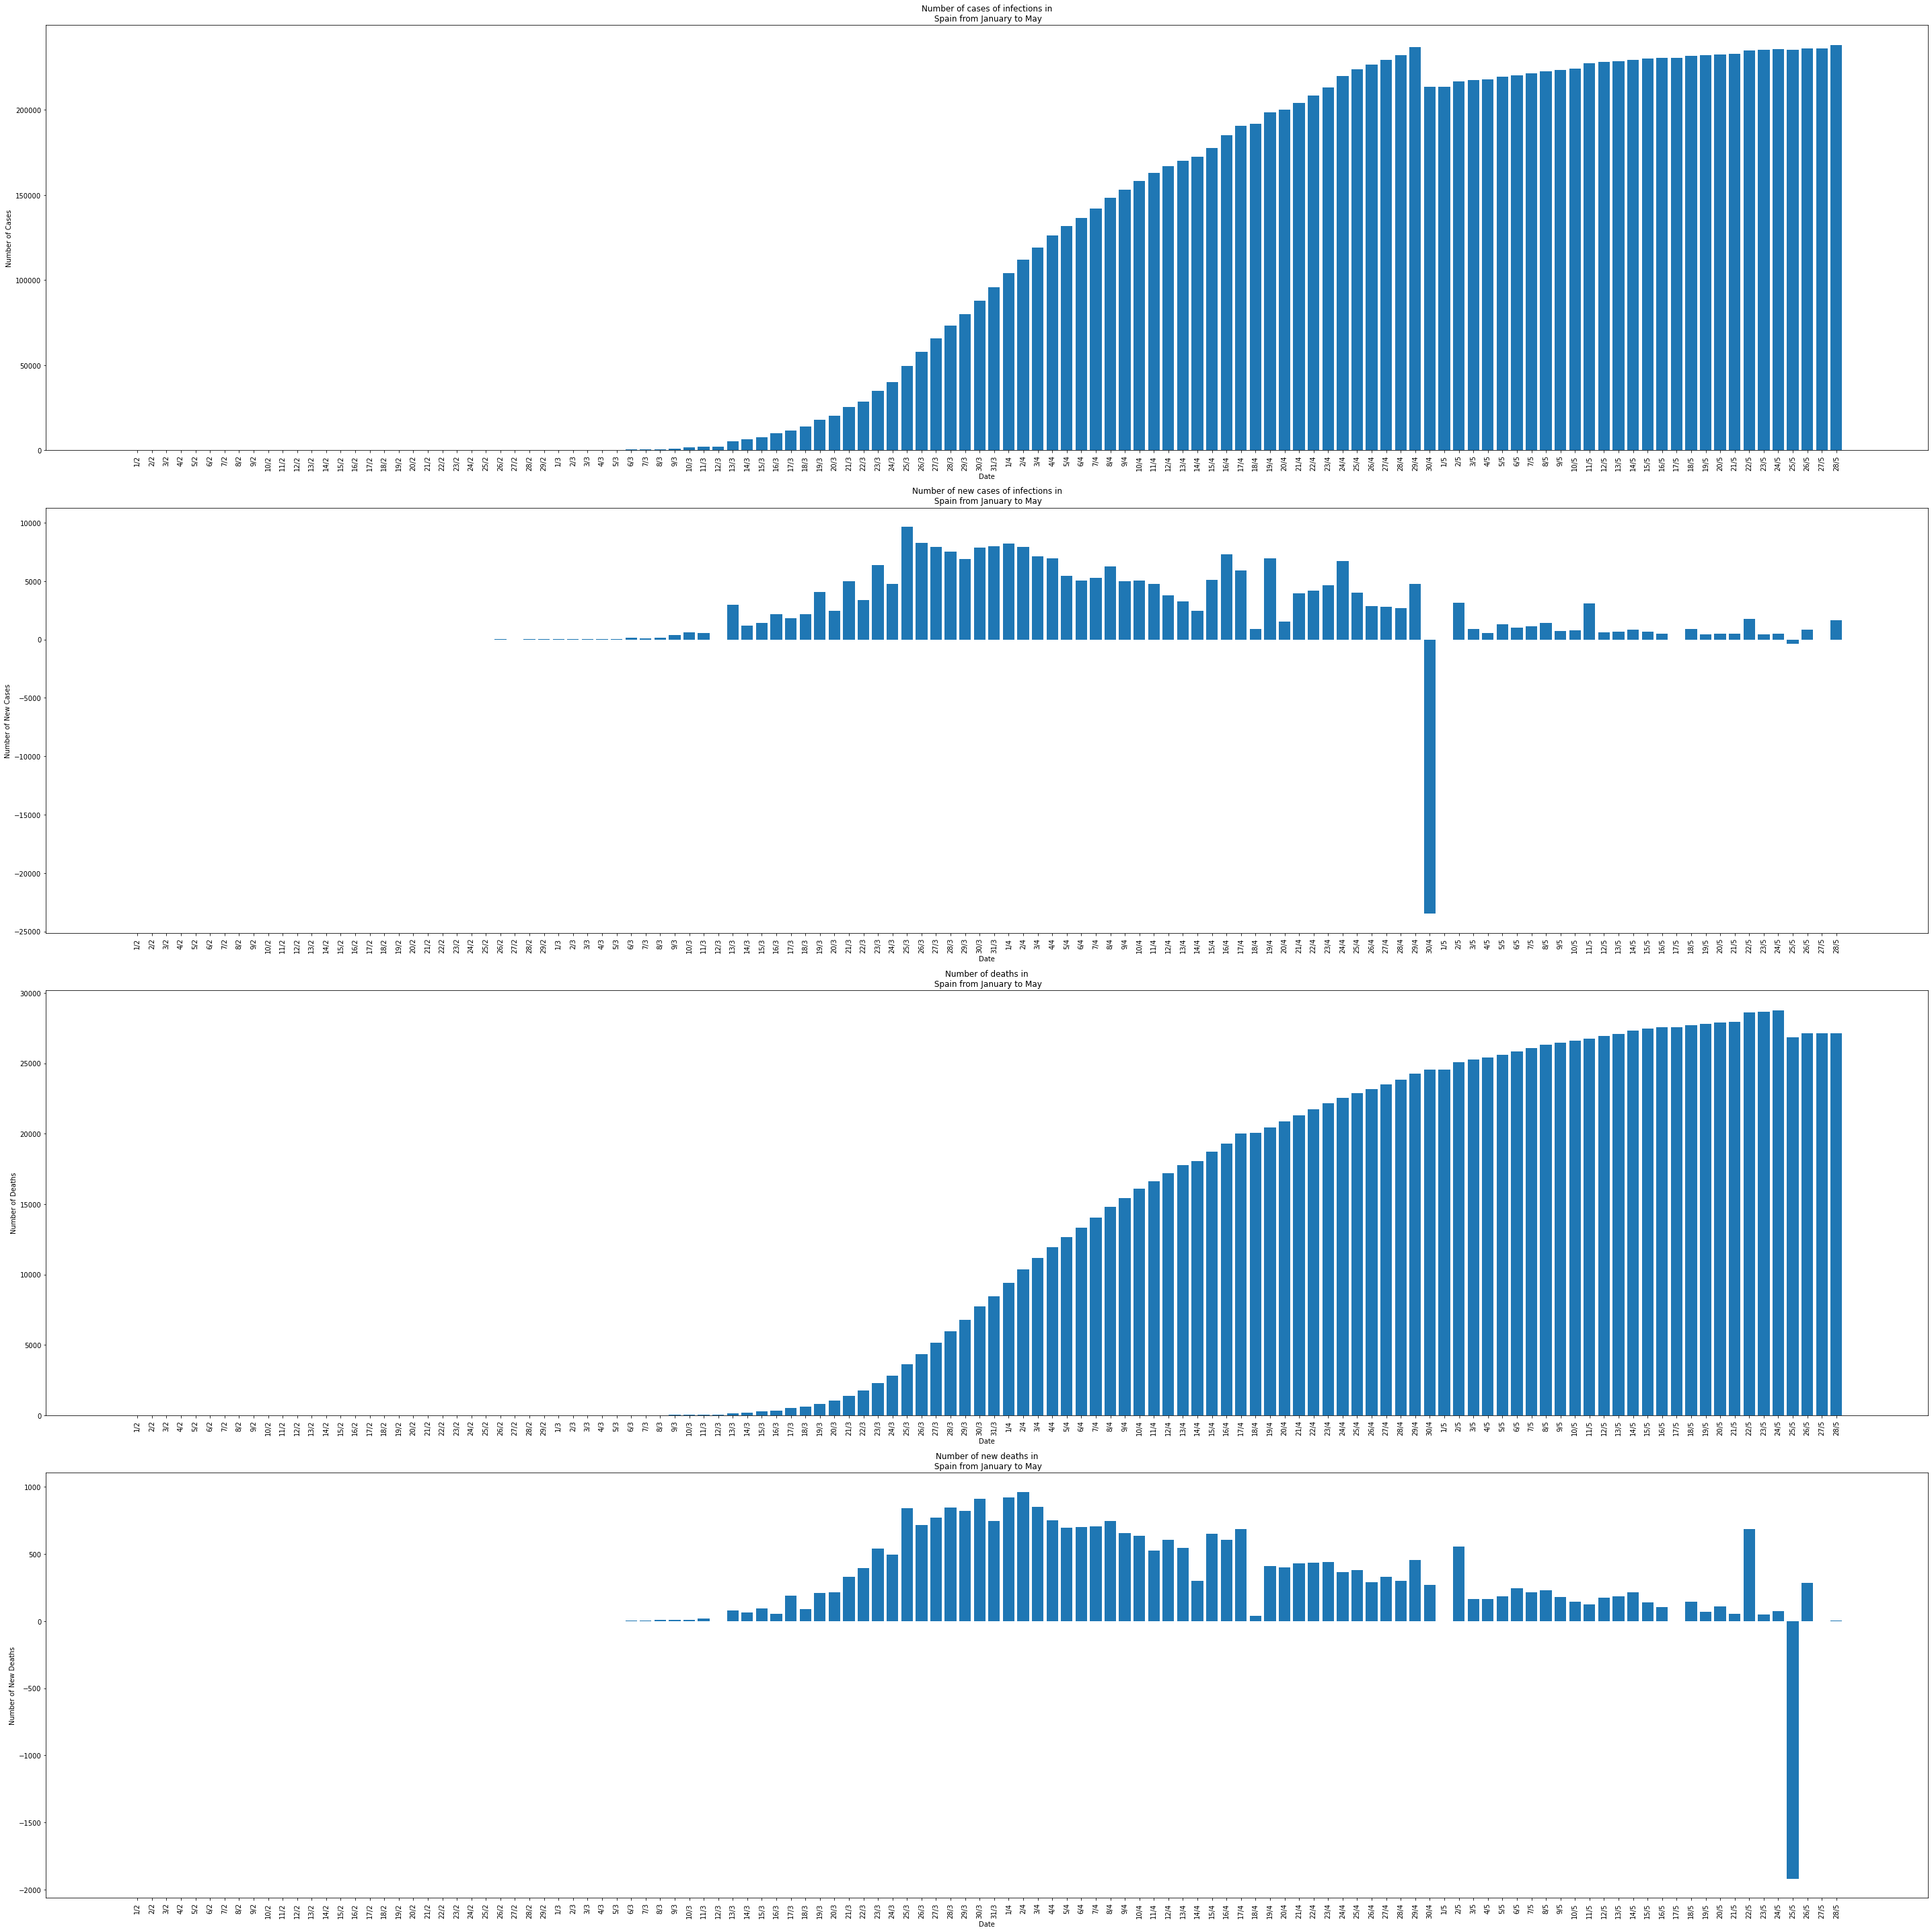

In [62]:
plot_total('Spain')

### Plotting graphs for France

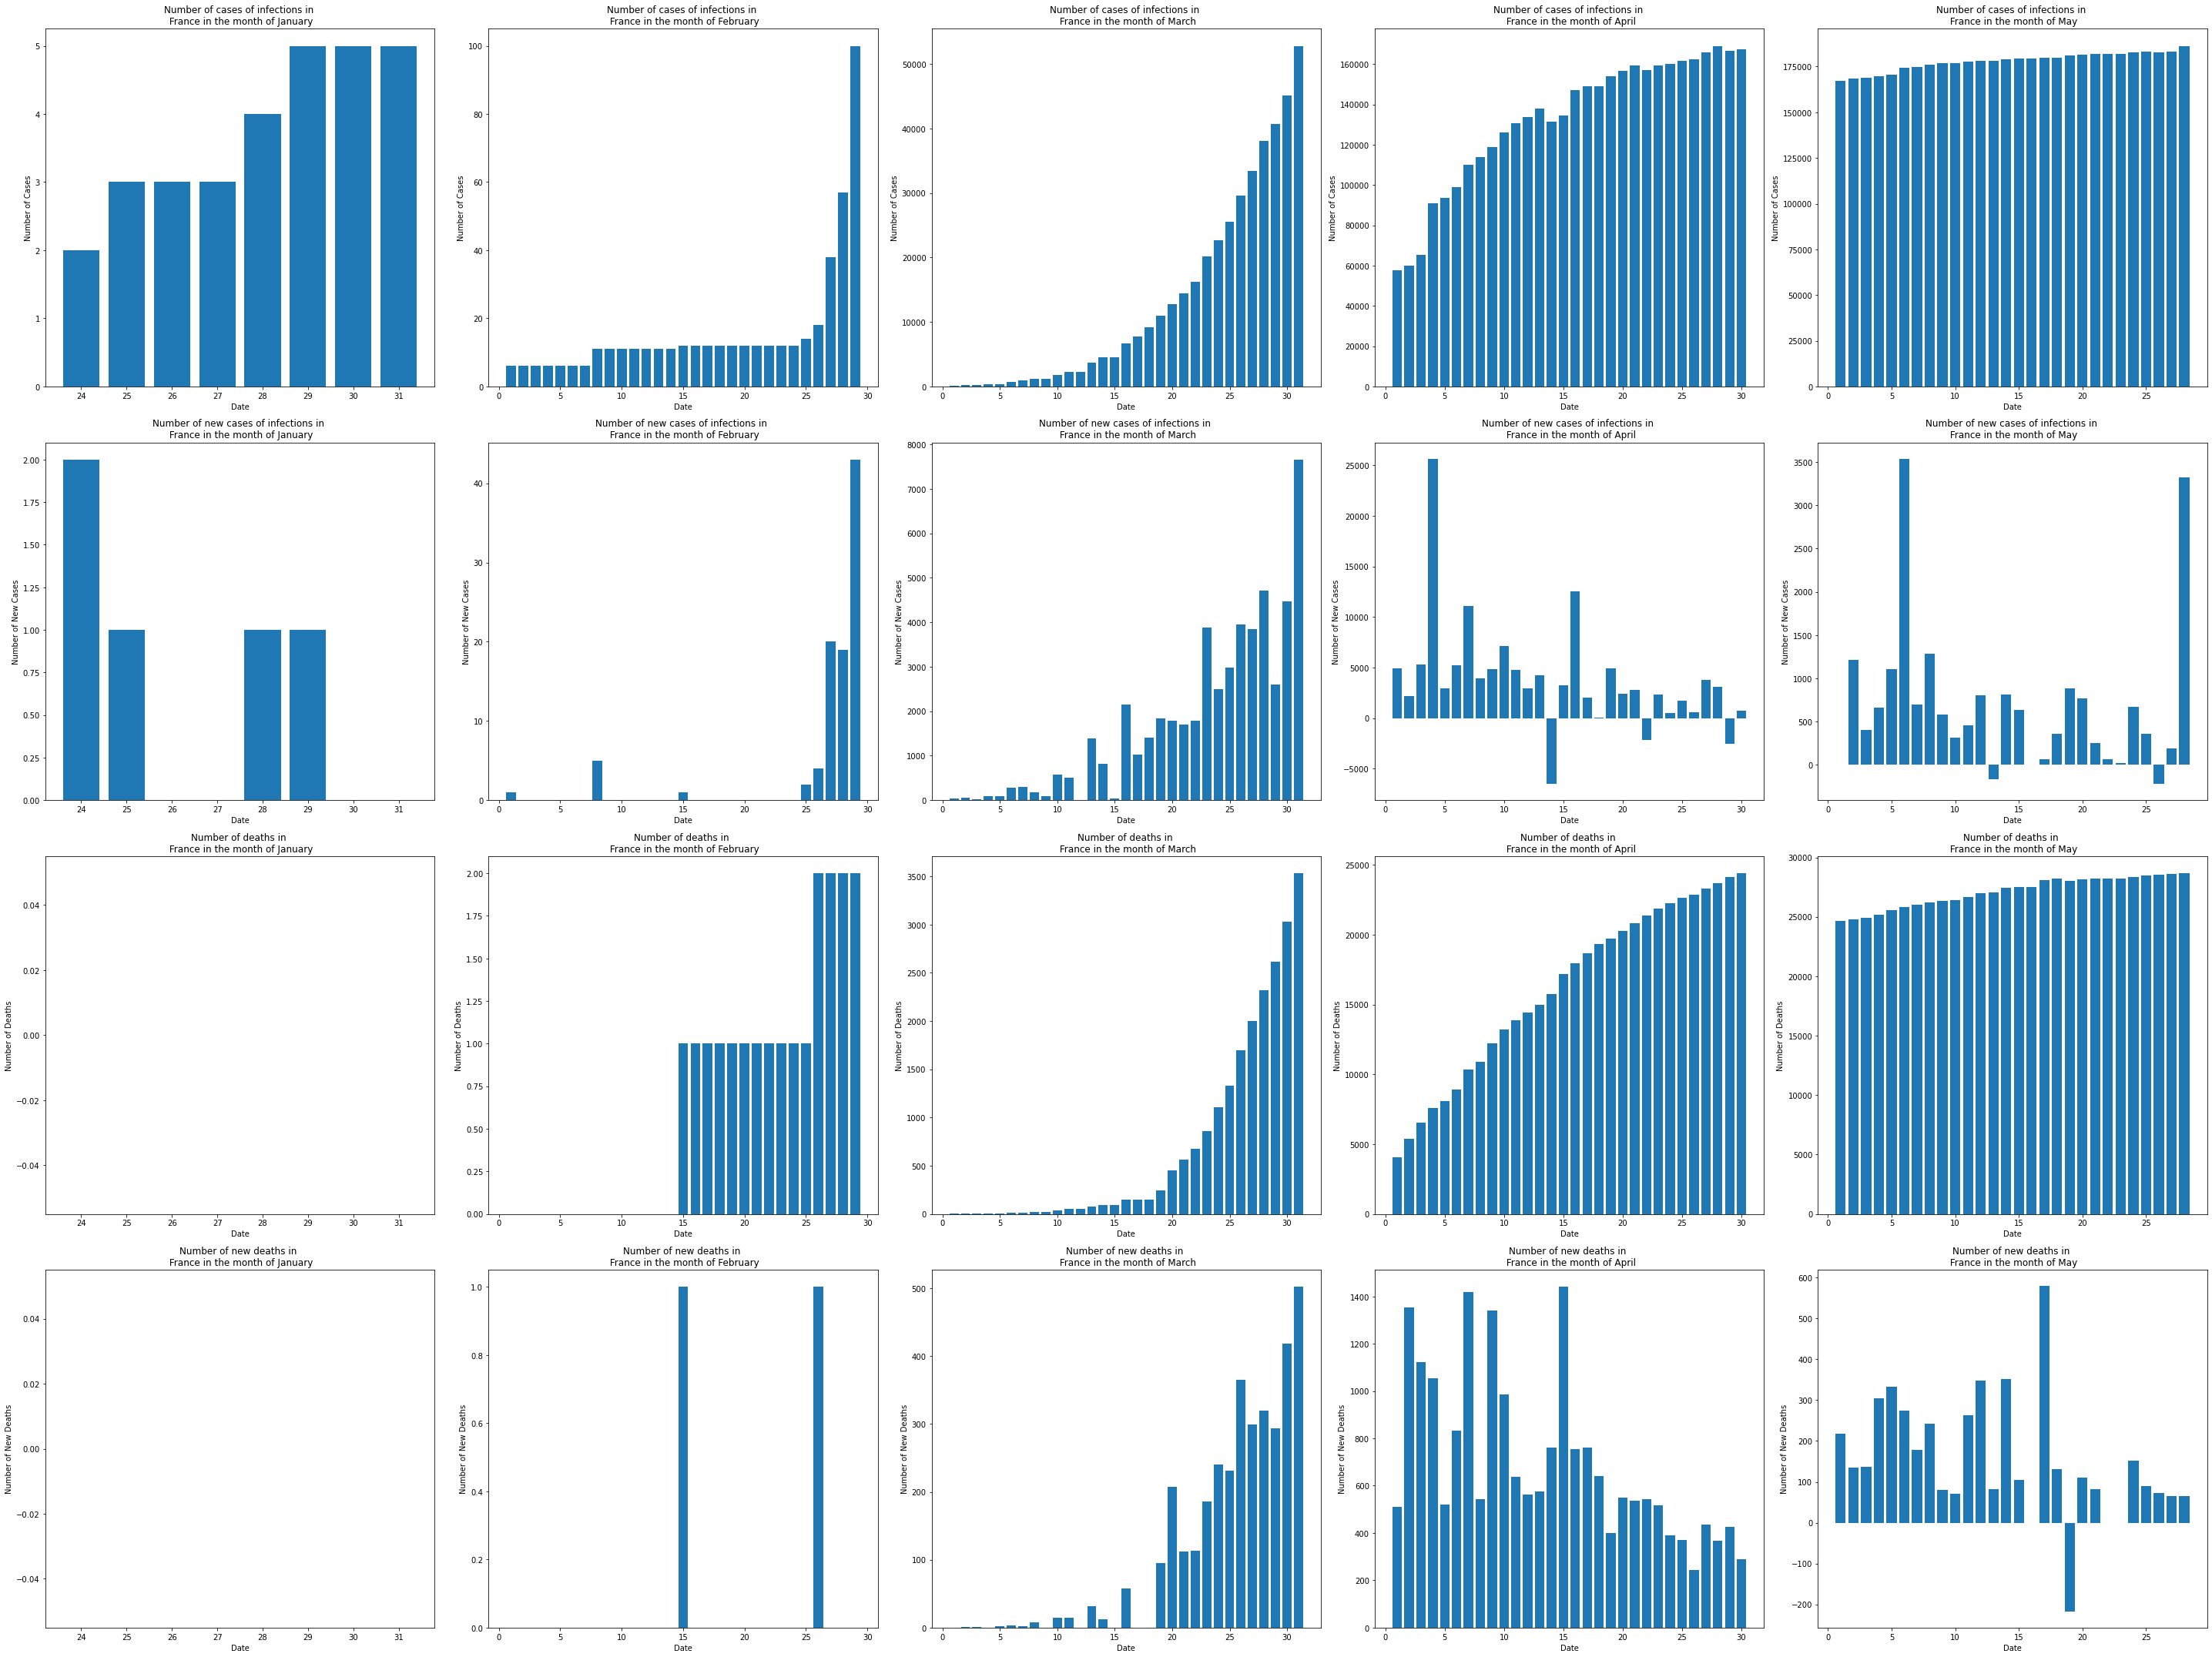

In [63]:
plot_monthwise('France')

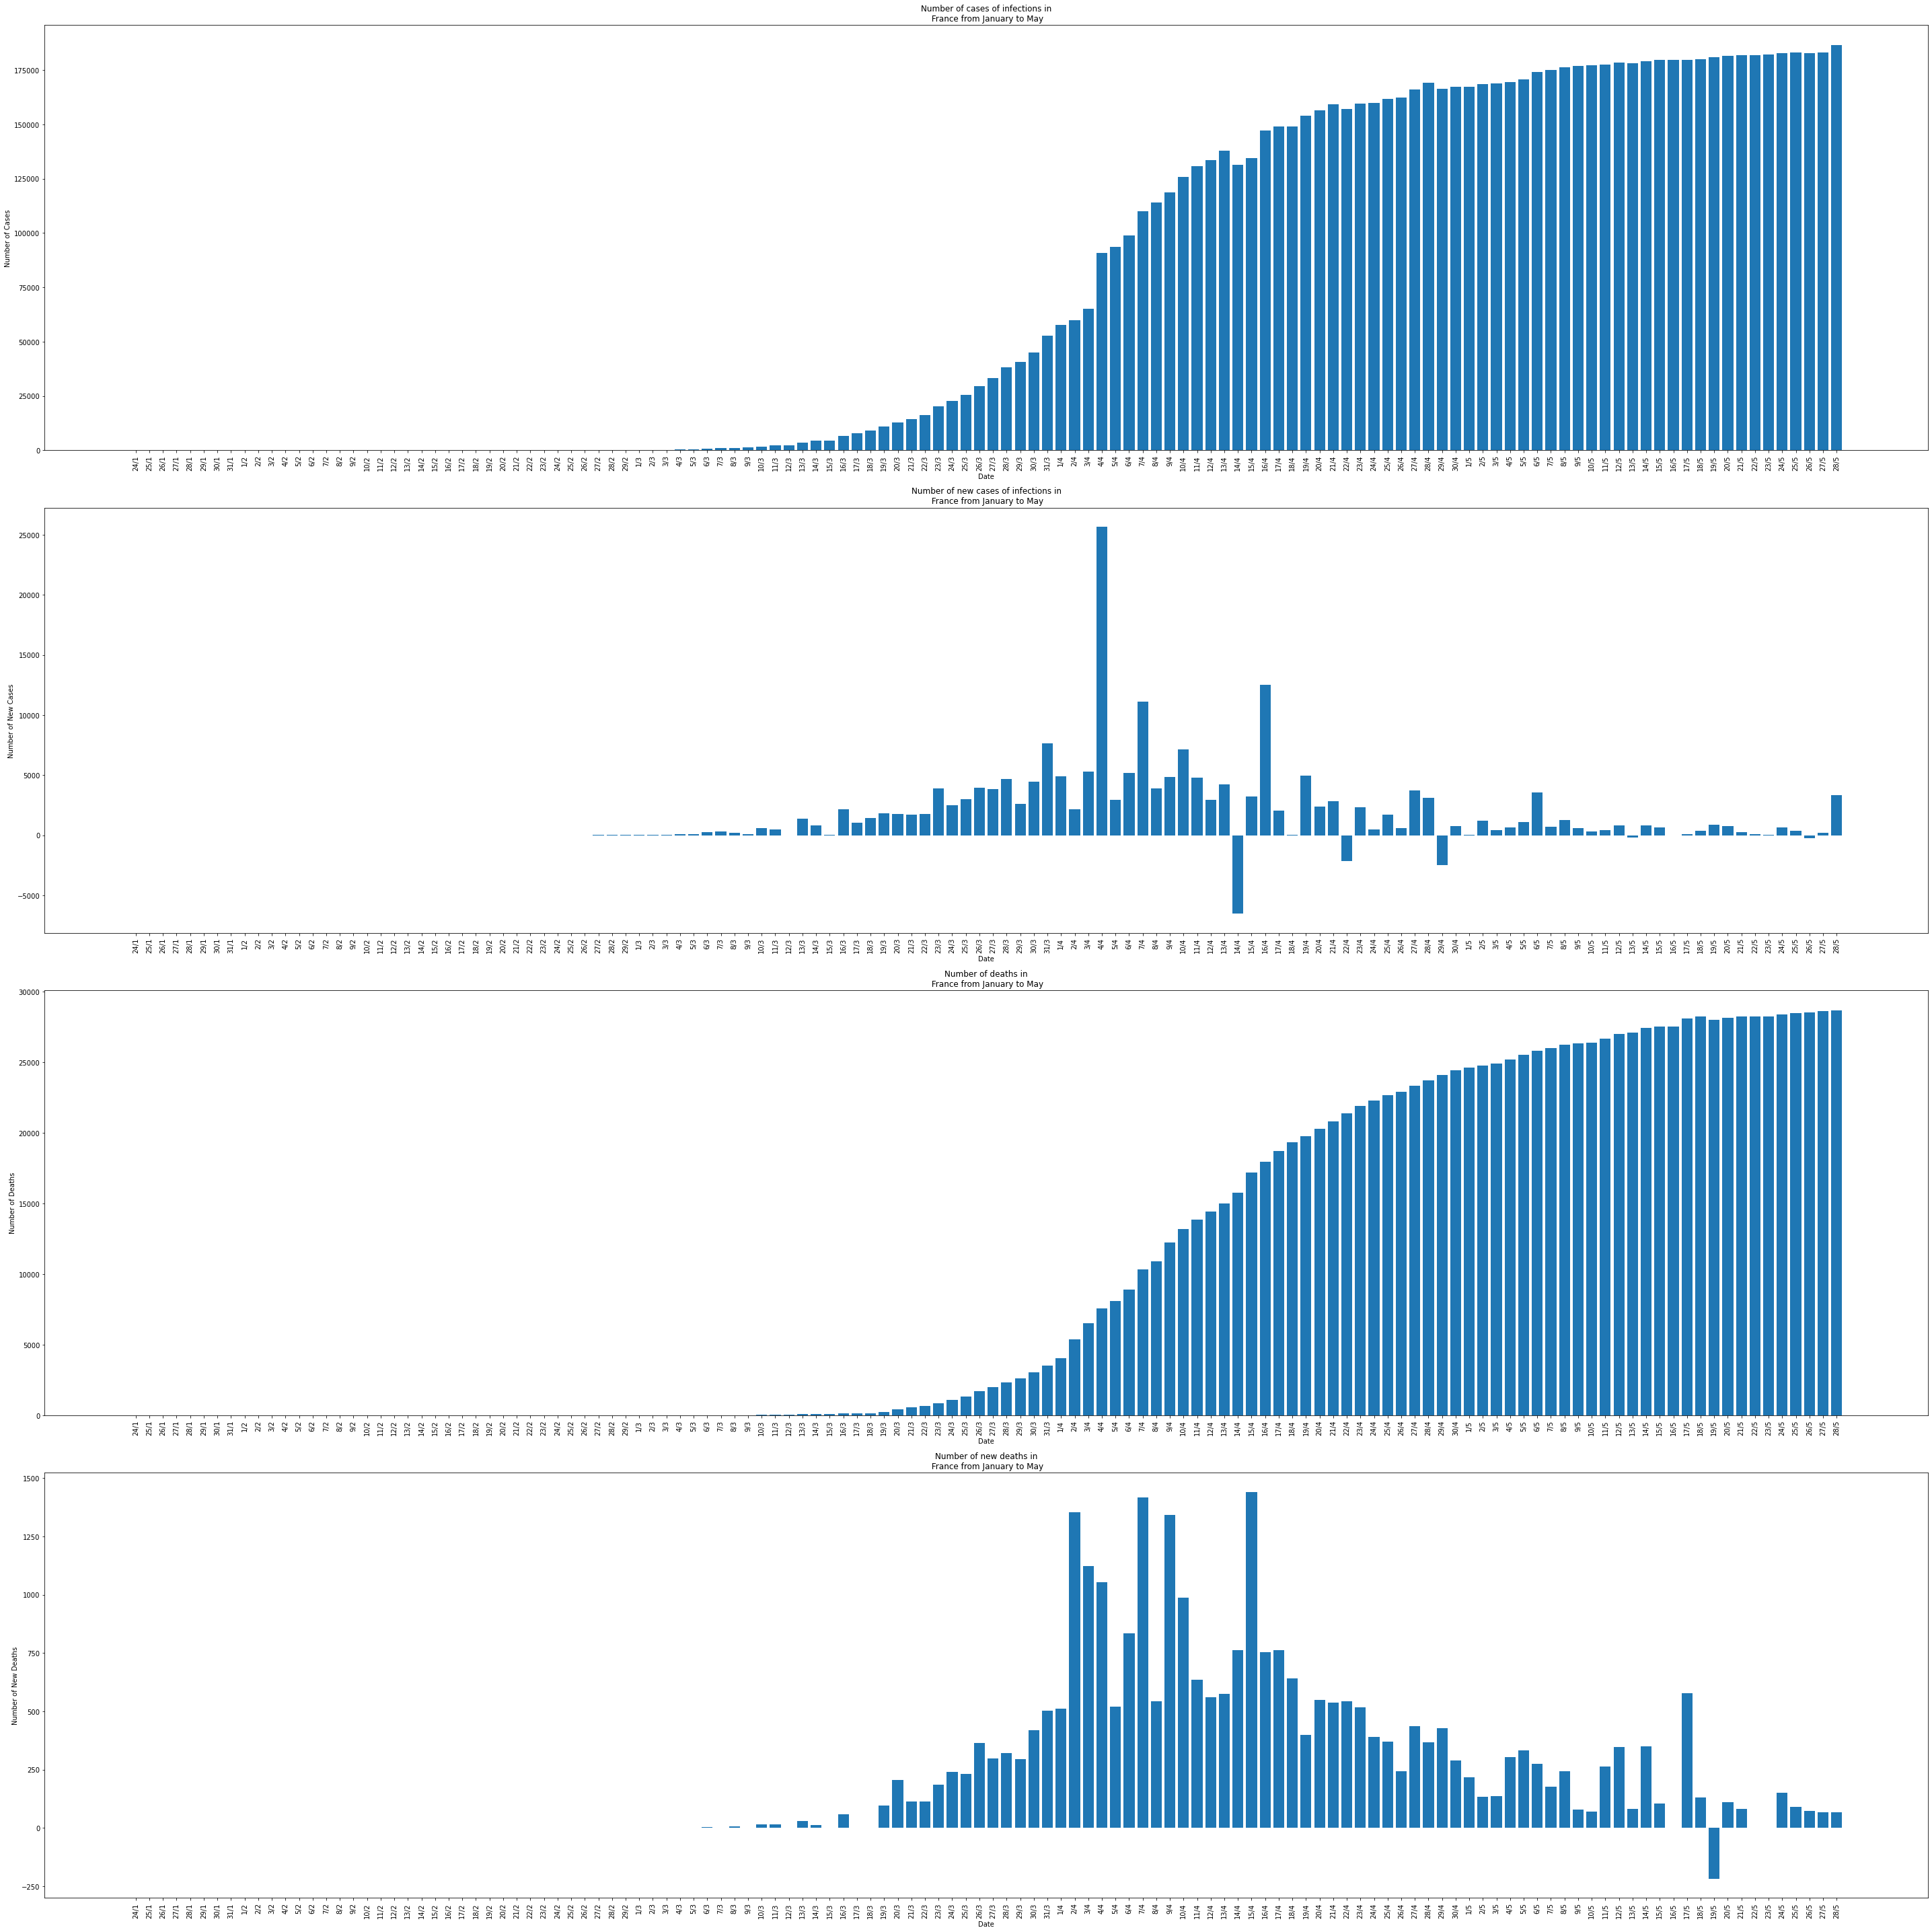

In [64]:
plot_total('France')

### Plotting graphs for India

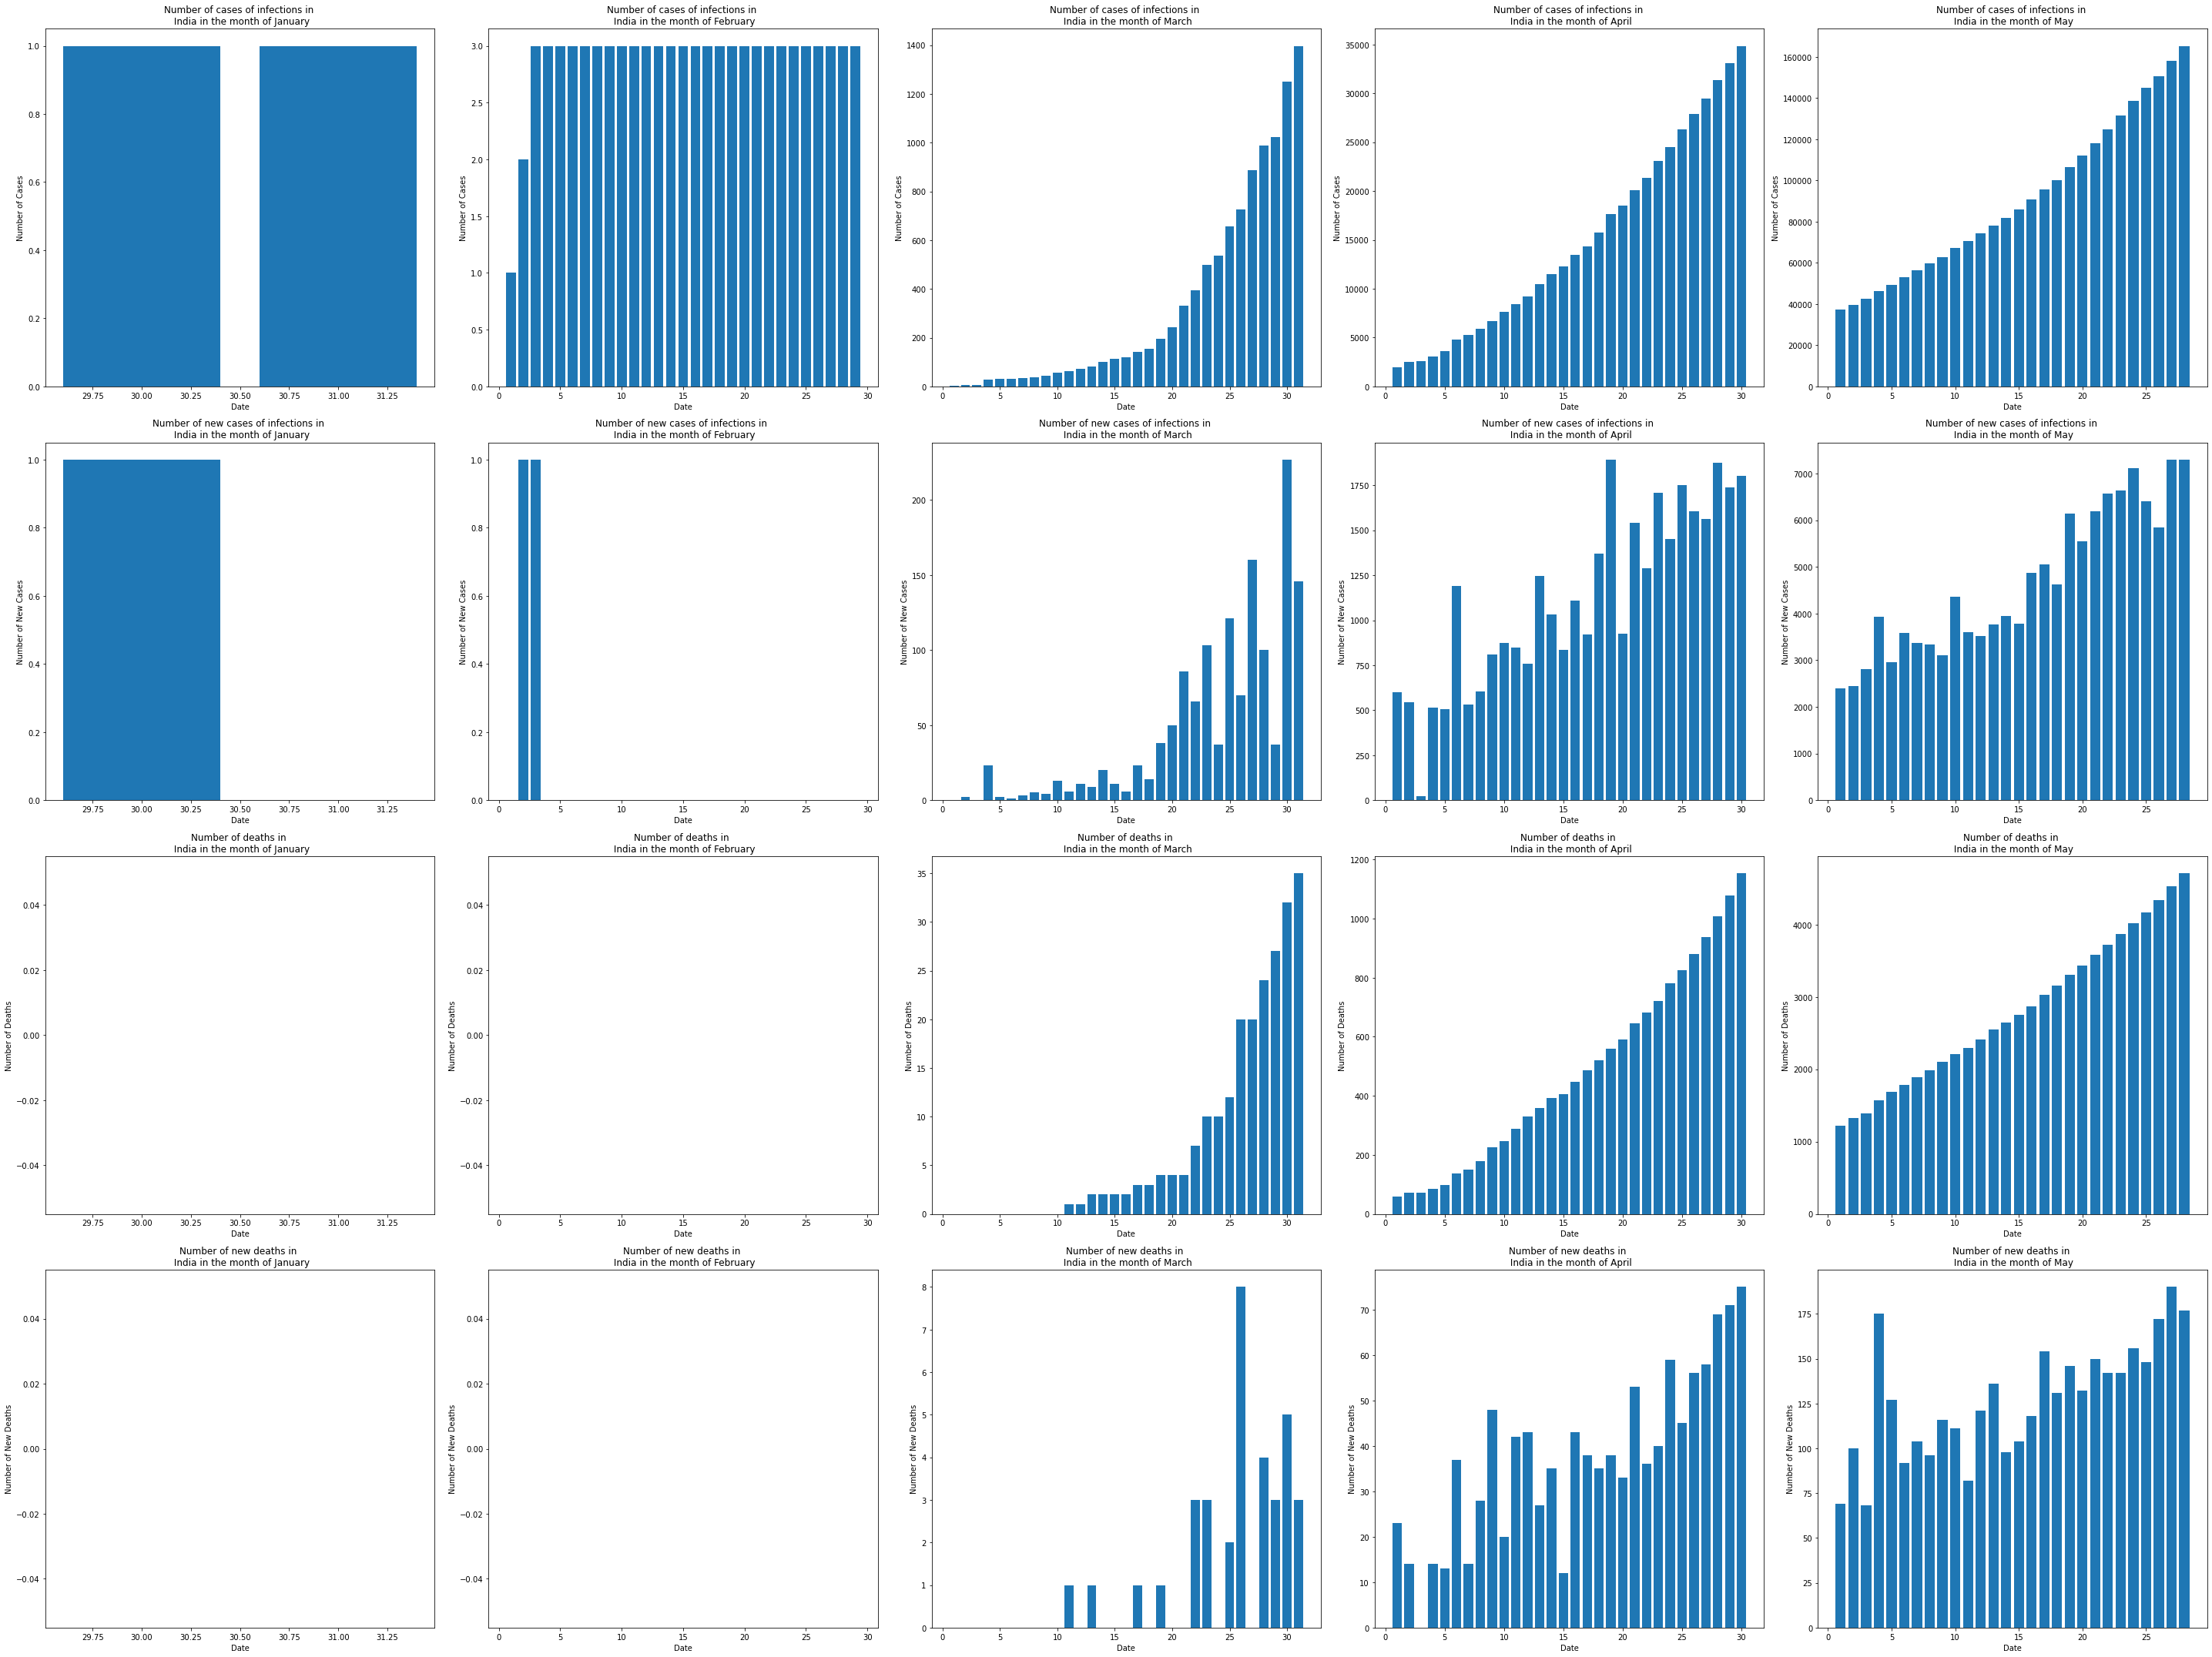

In [51]:
plot_monthwise('India')

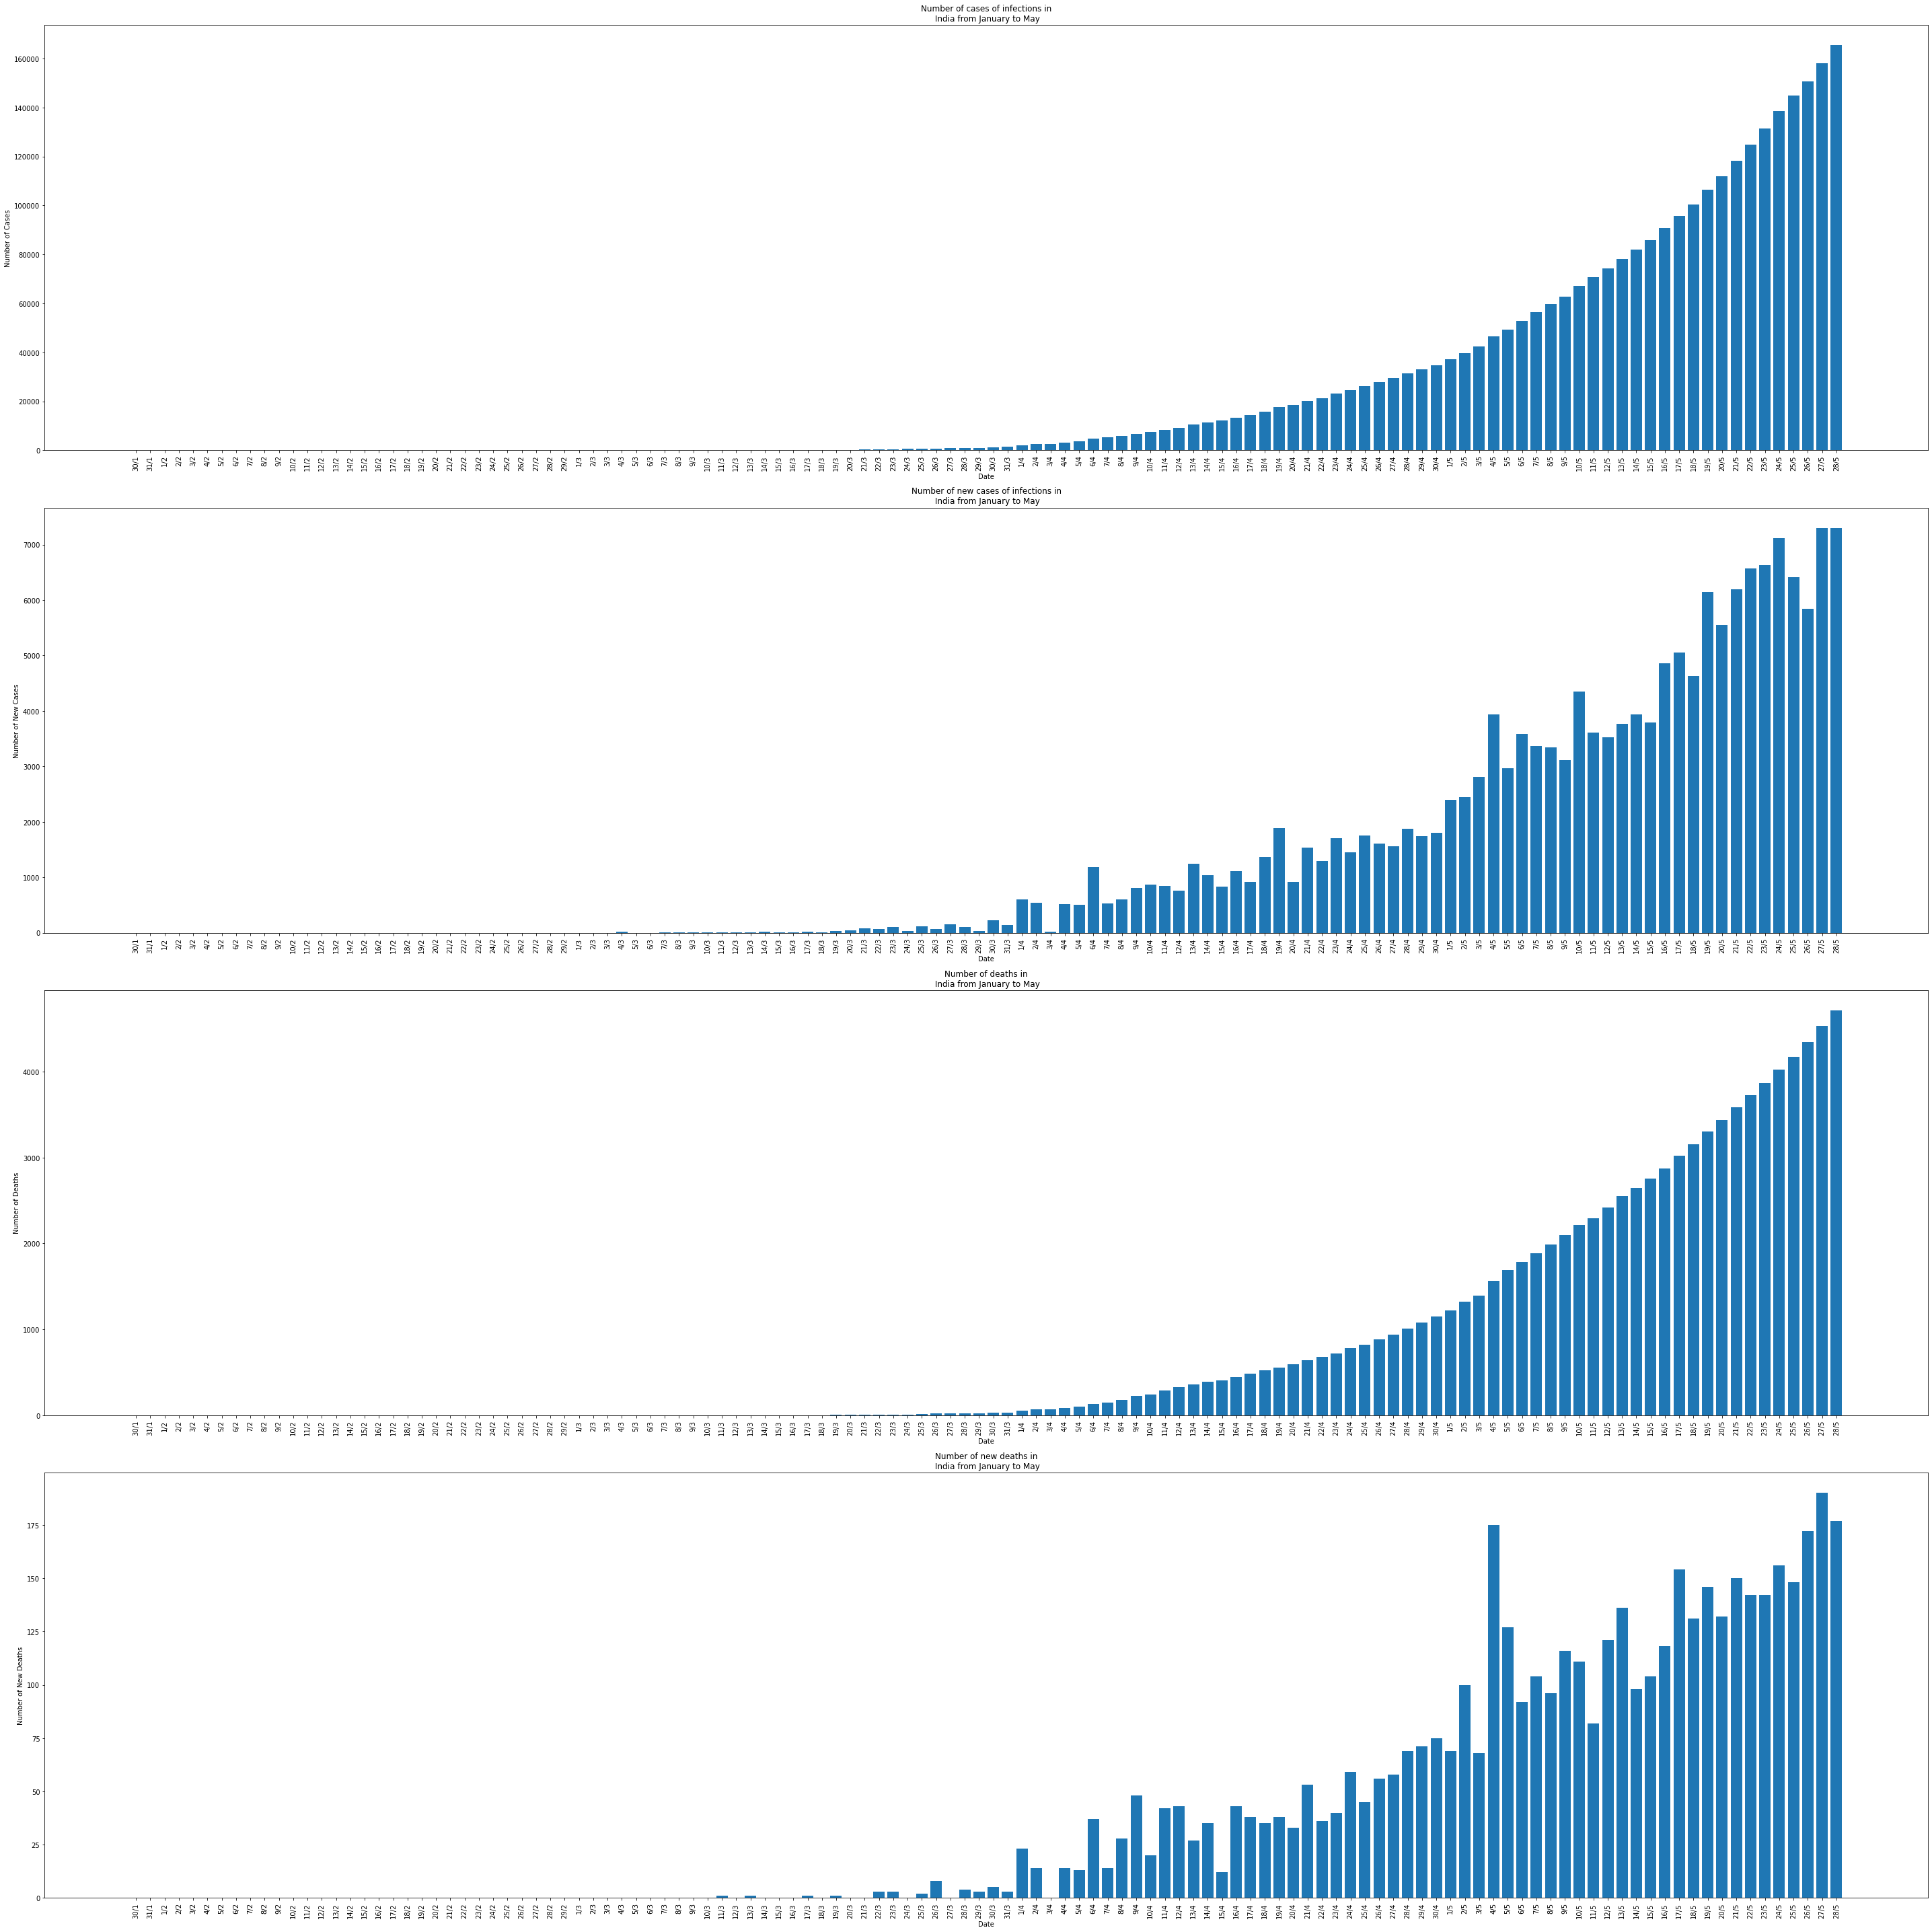

In [52]:
plot_total('India')

### Creating a new DataFrame
df3 will be containing the number of cases everyday in the world instead of just a particular country

In [53]:
dates = []
months = []
confirmed = []
deaths = []
new_cases = []
new_deaths = []
combined_dates = []

for month in df2.Month.unique():
    temp = df2[df2['Month'] == month]
    for date in temp.Date.unique():
        temp1 = temp[temp['Date'] == date]
        dates.append(date)
        months.append(month)
        confirmed.append(temp1['Confirmed'].sum())
        deaths.append(temp1['Death'].sum())
        new_cases.append(temp1['New_cases'].sum())
        new_deaths.append(temp1['New_deaths'].sum())
        combined_dates.append(temp1['Combined_Date'].unique()[0])

In [54]:
df3 = pd.DataFrame({'Date': dates,
                    'Month': months,
                    'Confirmed': confirmed,
                    'Death': deaths,
                    'New_cases': new_cases,
                    'New_deaths': new_deaths,
                    'Combined_Date': combined_dates
                   })

### Adding serial number column to df3

In [55]:
df3.insert(0, 'Ixs', np.arange(1, len(df3)+1))

In [56]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Ixs            128 non-null    int32 
 1   Date           128 non-null    int64 
 2   Month          128 non-null    int64 
 3   Confirmed      128 non-null    int64 
 4   Death          128 non-null    int64 
 5   New_cases      128 non-null    int64 
 6   New_deaths     128 non-null    int64 
 7   Combined_Date  128 non-null    object
dtypes: int32(1), int64(6), object(1)
memory usage: 7.6+ KB


### Plotting graphs for the world

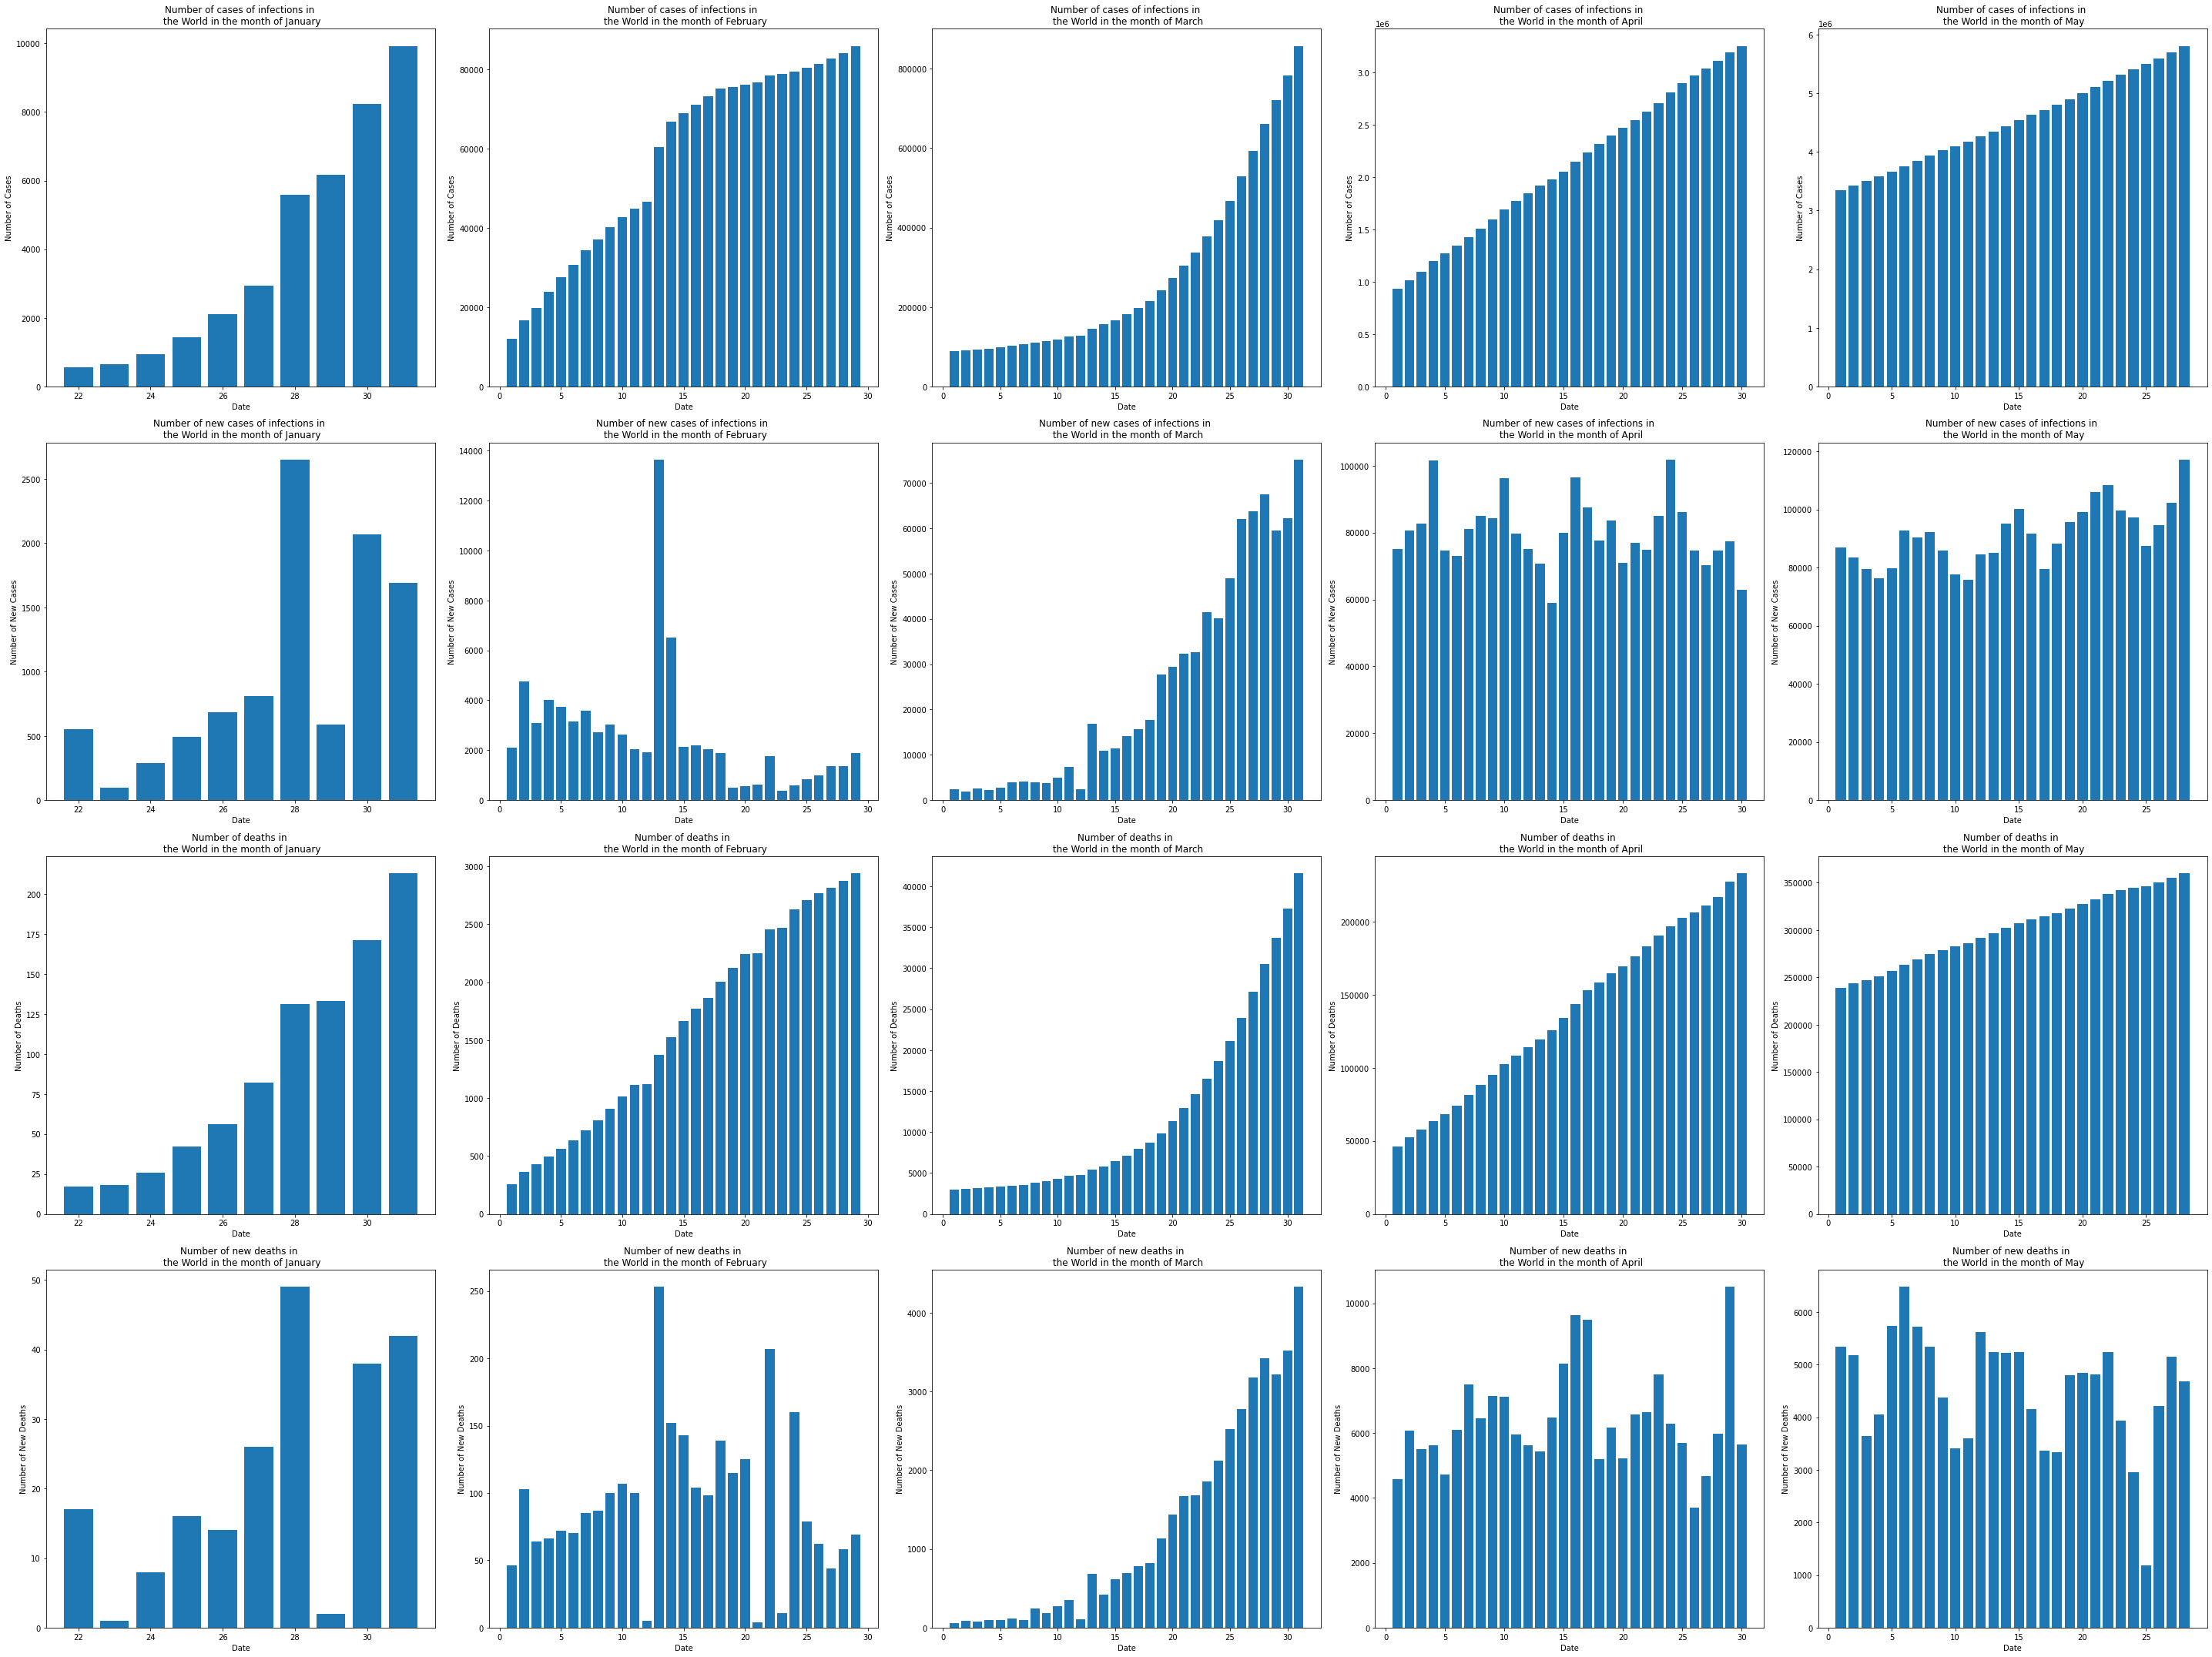

In [57]:
plot_monthwise('the World', sub_group = False)

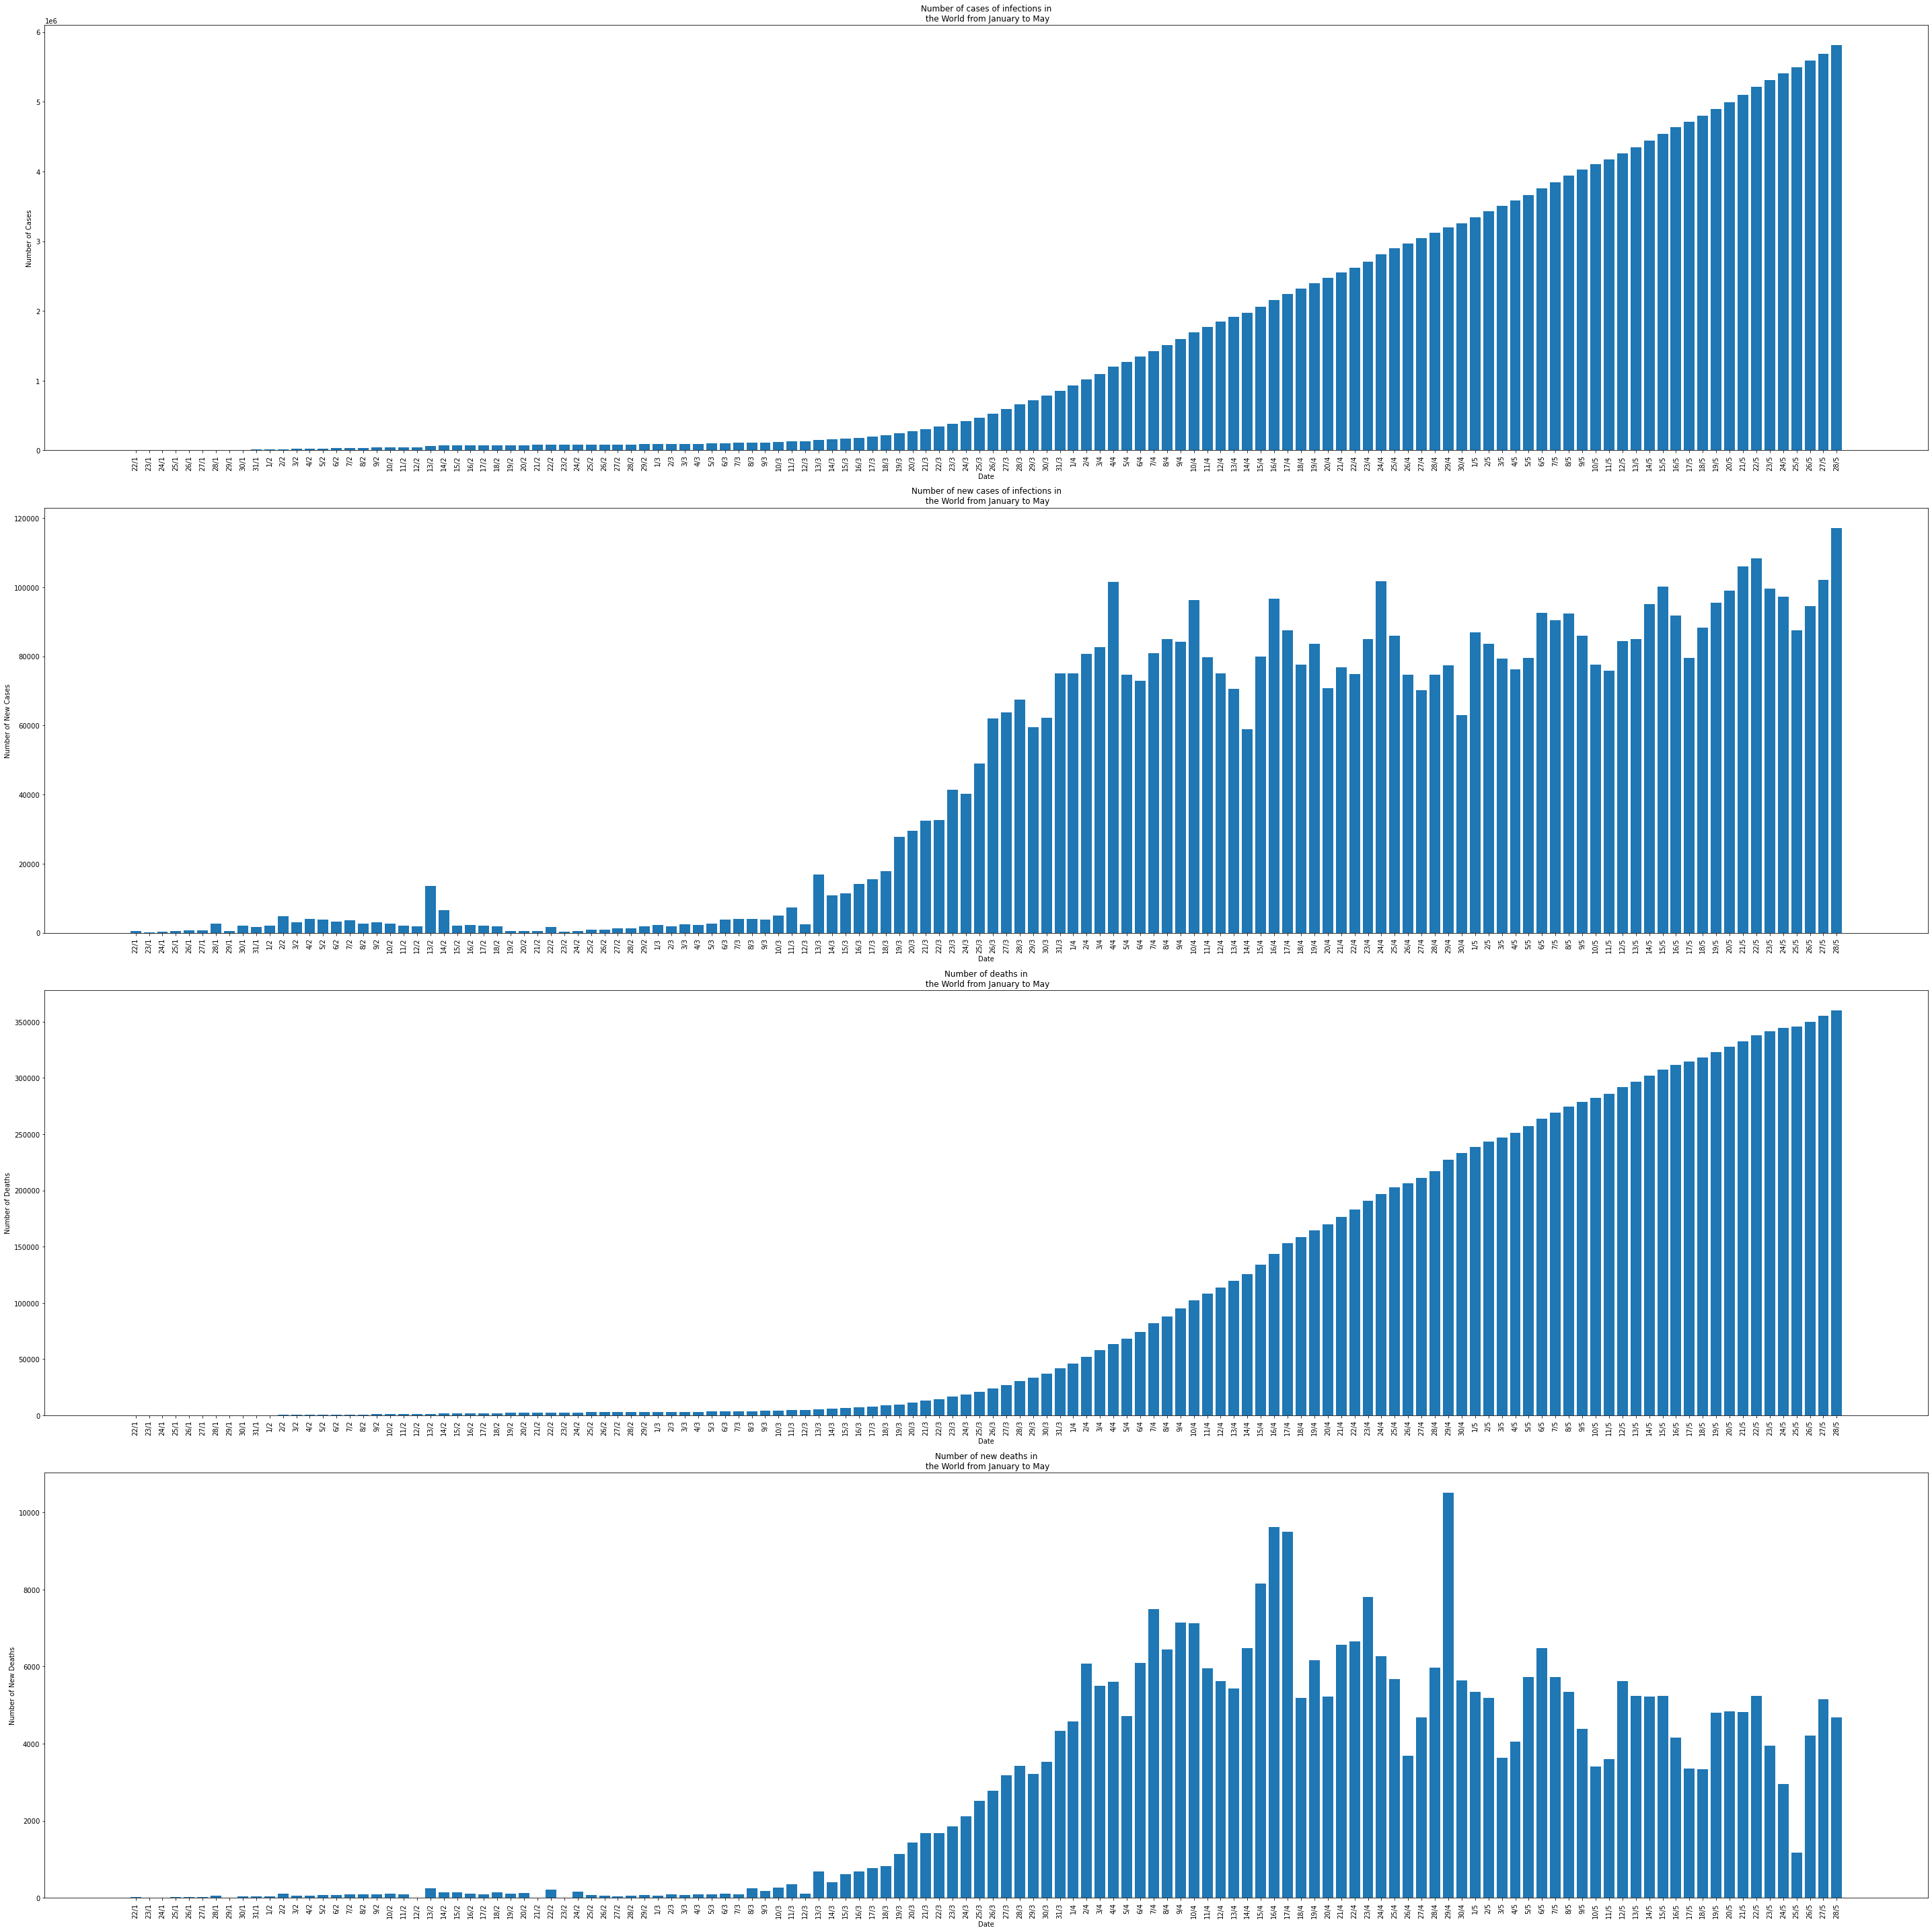

In [58]:
plot_total('the World', sub_group = False)